In [ ]:
# Auto_plume_ID.ipynb

# This is the first programme of SOFT-IO-LI and it searches the IAGOS database for new NOx (IAGOS CORE) or NO and NO2 (CARIBIC)
# flights to analyse. A check is made to ensure the PV variable is included in the dataset, if not it is added.
# It searches for excess NOx (NO + NO2) above the 75th percentile of the NOx measured during the flight and identifies NOx plumes.
# It selects the plumes if they are measured during the cruise phase of the flight, if there are no stratospheric influences 
# (PV > 2 K m2 kg-1 s-1 and if the CO and O3 are below 100 ppb.
# Short plumes (<12km) are removed as most probably being from aviation emissions.
# The plume information, arrival date and times required for FLEXPART are extracted and saved and plots are made of the remaining plumes
# to enable checks to be easily made.

# C. Mackay September 2022 (Catherine.Mackay@aero.obs-mip.fr)
# https://github.com/ckmackay/SOFT-IO-LI.git

#Suggestions/improvements to be made:

# function find_untested_NOx_flights()
# Once NOx lightning data is added to the IAGOS db we need to include a check so as not to reanalyse any flights.

# function apply_cuts()
# CO and O3 cut at 100 ppb, this could be changed to 75th percentile of CO/O3 in that region, that month. Code to calculate these is in github.
# A quick check did not see any obvious improvment in doing this.

""" Remarques
    - faire qqchose pour les variables globales
    - pour IAGOS_CORE et IAGOS_CARIBIC --> pas mal de trucs identiques, peut-être répétitions pas nécessaire parfois ?
    - voir si garde colonnes de bool ou si on drop les trucs qui sont pas intéressants ? (peut-être qu'il y en a besoin pour d'autres valeurs en fait ?)
"""

In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import json

import logging
import os

#for plotting
import matplotlib.pyplot as plt

#for datetime
import datetime
from datetime import datetime as dt
import matplotlib.dates as mdates
from matplotlib.dates import date2num

### Constantes

In [3]:
NOx = 'NOx'
NO = 'NO'
NO2 = 'NO2'

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.NOTSET) ## main logger level must be equal or lower than handler log level

### set_console_logger

In [7]:
def set_console_logger(log_level=logging.INFO):
    """
    Function to set console logs
    :param log_level: log level value (DEBUG, INFO, WARNING, ERROR or CRITICAL), logging.INFO by default
    """
    # if logger already has stream handlers, remove all of them before adding new one
    if any(isinstance(h, logging.StreamHandler) for h in logger.handlers):
        for h in logger.handlers:
            if isinstance(h, logging.StreamHandler):
                logger.removeHandler(h)
            
    # create console handler and set level to info
    console_handler = logging.StreamHandler(stream=sys.stdout)
    console_handler.setLevel(log_level)
    # add console handler to logger
    logger.addHandler(console_handler)
    
    logger.info("Console logger set!")

### set_file_logger

In [8]:
def set_file_logger(result_dir_path, log_nb=1):
    """
    Function to set console logs and log file
    :param result_dir_path: path of the directory where the log file will be stored
    :param log_level: log level value (DEBUG, INFO, WARNING, ERROR or CRITICAL), logging.DEBUG by default
    :param log_nb: log file number
    """
    # if logger already has file handlers, remove all of them before adding new one
    if any(isinstance(h, logging.FileHandler) for h in logger.handlers):
        for h in logger.handlers:
            if isinstance(h, logging.FileHandler):
                logger.removeHandler(h)
        
    # create file handler and set level to debug
    file_handler = logging.FileHandler(filename=os.path.join(result_dir_path,'logs-{:02d}.logs'.format(log_nb)), mode='w')
    file_handler.setLevel(logging.DEBUG)
    # create formatter and add it to file handler
    formatter = logging.Formatter('[%(levelname)s] %(asctime)s - %(funcName)s : %(message)s')
    file_handler.setFormatter(formatter)
    # add file handler to logger
    logger.addHandler(file_handler)
    
    logger.info("File logger set!")

### create_result_dir

In [9]:
def create_result_dir(result_path, res_dir_name, test_nb=1):
    """
    Function to create the directories in which the results of Auto_plume_ID will be stored
    <main_result_directory>
        |-- Plume_info_all_cuts
        |-- plots
        |-- flight_time_txt
    :param result_path: <str> directory in which we want to create the result directories (absolute path)
    :param res_dir_name: <str> name of the result directory
    :param test_nb: <int> (optional) test number
    :return: <dict> dictionary containing the sub directories path 
    """
    
    dict_result_path = {}
    subdir_list = ['Plume_info_all_cuts', 'plots', 'flight_time_txt']
    current_date = dt.now()
    
    # create directory name: MM-DD_test-<test_nb>_<res_dir_name>
    dir_name = '{:02d}-{:02d}_test-{:02d}_{}'.format(current_date.month, current_date.day, test_nb, res_dir_name)
    full_path = os.path.join(result_path, dir_name)
    dict_result_path['result_dir'] = full_path 
    
    # check that dir does not already exist
    if not os.path.exists(full_path):
        os.mkdir(full_path)
        logger.debug(f"{full_path} created")
    # if directory already exists --> print error message
    else:
        logger.warning(f'{full_path} already exists !')
        
    # create subdirectories
    for subdir_name in subdir_list:
        subdir_path = os.path.join(full_path,subdir_name)
        # if subdirectory does not exist, we create it
        if not os.path.exists(subdir_path):
            os.mkdir(subdir_path)
            logger.debug(f"{subdir_path} created")
        # if directory already exists print a warning ##### for now, need to decide if we empty it or not
        else:
            logger.warning(f'{subdir_path} already exists !')
        # add subdirectory path to path dictionary
        dict_result_path[subdir_name] = subdir_path
    
    logger.debug(f"dict_result_path: {dict_result_path}")
    
    return dict_result_path

In [11]:
set_console_logger()

Console logger set!


In [12]:
############ TESTS ############
print(create_result_dir('/o3p/patj', 'coucou', 155))
###############################

{'result_dir': '/o3p/patj/05-31_test-155_coucou', 'Plume_info_all_cuts': '/o3p/patj/05-31_test-155_coucou/Plume_info_all_cuts', 'plots': '/o3p/patj/05-31_test-155_coucou/plots', 'flight_time_txt': '/o3p/patj/05-31_test-155_coucou/flight_time_txt'}


In [14]:
set_file_logger('/o3p/patj/05-31_test-155_coucou')

File logger set!


In [15]:
logger.handlers

[<StreamHandler stdout (INFO)>,
 <FileHandler /o3p/patj/05-31_test-155_coucou/logs-01.logs (DEBUG)>]

### set_paths() <!> CHANGER LES PATHS !!!!

In [10]:
### Check the following paths and settings: these are set for SOFT-IO-LI default on nuwa in /o3p/iagos/SOFT-IO-LI
### For testing, think of creating /o3p/user/SOFT-IO-LI/ and changing the paths below. 
### you will need to create the following directories:
### /o3p/user/SOFT-IO-LI/FLEXPART_templates
### /o3p/iagos/SOFT-IO-LI/Plume_info_all_cuts/
### /o3p/iagos/SOFT-IO-LI/flight_time_txt/
""" Remarques:
    - return un dict avec les paths au lieu de variables globales ?
    - prendre path output et nom dossier en param ?
"""

def set_paths():
    global iagos_cat, PV_path, plume_info_path, plume_plots_path, flight_time_path, root_result_path
    
    iagos_cat = '/o3p/iagos/catalogues/'
    PV_path='/o3p/iagos/L4/L2-ECMWF-PV-CO_contributions/'
    
    ### create results directory and subdirectories
    dict_dir = create_result_dir('/o3p/patj/SOFT-IO-LI_output/', 'new-version-vol2018060508235702-remove-plane', 4)
    
    # initialise file logger
    set_file_logger(dict_dir['result_dir'], 1)
    
    if len(dict_dir) > 1:
        plume_info_path = dict_dir['Plume_info_all_cuts'] #'/o3p/patj/SOFT-IO-LI_output/test-0305-02-fullAutoPlume-vols060718-sorted/Plume_info_all_cuts/'
        plume_plots_path = dict_dir['plots'] #'/o3p/patj/SOFT-IO-LI_output/test-0305-02-fullAutoPlume-vols060718-sorted/plots/'
        flight_time_path = dict_dir['flight_time_txt'] #'/o3p/patj/SOFT-IO-LI_output/test-0305-02-fullAutoPlume-vols060718-sorted/flight_time_txt/'
        root_result_path = dict_dir['result_dir']
    else:
        logger.error("Unable to find path")

### <!> NE PAS run ça si tests vols 2018

In [31]:
# Search for NOx flights
# Using the catalogues search for any flights with NOx measurements
# Make a list of their locations
# Return the number of flights found

### Nb. Once NOx lightning data is added to the db we need to include a check so as not to reanalyse any flights
''' <!> does not include check to see if flight has already been analysed or not <!> '''
def find_untested_NOx_flights():
    global flights_with_NOx, df
    #df = pd.read_hdf('/o3p/wolp/catalogues/iagos.h5', key='sources')
    df = pd.read_hdf(iagos_cat+'iagos_L2.h5', key='sources')
    #novars = [c for c in df if c.startswith("data_vars_") and ("NOx") in c] #selects only IAGOS-CORE flights (210 in total)
    novars = [c for c in df if c.startswith("data_vars_") and ("NO2") in c] #selects IAGOS-CORE & IAGOS-CARIBIC flights (669 in total)

    flights_with_NOx = df.loc[(df[novars] > 0).any(axis="columns")]
    #print(novars)
    print(len(flights_with_NOx), 'flights containing NOx measurements')
    
    return

### custom_find_NOx_flights

In [5]:
# va chercher chemins des fichiers netcdf pour les vols 2018
# + met au même format que ce qu'aurait retourné the original find_untested_NOx_flights
def find_untested_NOx_flights():
    global flights_with_NOx
    NOx_flights_path = '/o3p/patj/NOx-flights_juin-juillet18/'
    NOx_flights_files = [{"drivers_load_args": str({"args": [os.path.join(NOx_flights_path, file)], "kwargs": {}}).replace("'", '"')} for file in sorted(os.listdir(NOx_flights_path))]
    flights_with_NOx = pd.DataFrame(NOx_flights_files)
    print(len(flights_with_NOx), 'flights containing NOx measurements')

### Launch set_paths and find_untested_NOx_flights() + affichage perso

In [30]:
# Set paths & fetch the NOx flight information
set_paths()
find_untested_NOx_flights()

created  /o3p/patj/SOFT-IO-LI_output/05-16_test-01_testNOouNO2-vols2018/Plume_info_all_cuts
created  /o3p/patj/SOFT-IO-LI_output/05-16_test-01_testNOouNO2-vols2018/plots
created  /o3p/patj/SOFT-IO-LI_output/05-16_test-01_testNOouNO2-vols2018/flight_time_txt
30 flights containing NOx measurements


In [39]:
#Check the list, optional
flights_with_NOx.drivers_load_args.iloc[0]

'{"args": ["/o3p/patj/NOx-flights-juin_juillet18/new_NOx_IAGOS_timeseries_2018060302172202.nc"], "kwargs": {}}'

In [9]:
''' ####################### test perso ####################### '''
### juste pour voir à quoi ressemble 1 vol dans un dataset xarray
flight_test = flights_with_NOx.drivers_load_args.iloc[0]
ds_test = xr.load_dataset(*json.loads(flight_test)["args"])
ds_test

<xarray.Dataset>
Dimensions:               (UTC_time: 9498)
Coordinates:
  * UTC_time              (UTC_time) datetime64[ns] 2018-06-03T02:17:38 ... 2...
Data variables: (12/43)
    lon                   (UTC_time) float64 -74.16 -74.16 ... 8.508 8.511
    lat                   (UTC_time) float64 4.705 4.704 4.702 ... 50.04 50.04
    baro_alt_AC           (UTC_time) float64 2.426e+03 2.426e+03 ... 53.6 58.8
    baro_alt_AC_val       (UTC_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    radio_alt_AC          (UTC_time) float64 0.3 0.3 0.2 0.3 ... 2.6 0.2 0.0 0.3
    gps_alt_AC            (UTC_time) float64 2.572e+03 2.572e+03 ... 105.8 105.8
    ...                    ...
    NO2_P2b_err           (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NO2_P2b_val           (UTC_time) float64 7.0 7.0 7.0 7.0 ... 0.0 2.0 7.0 7.0
    NOx_P2b               (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NOx_P2b_err           (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NOx_P2b_val           (UTC_time) float64 7.0 7.0 7.0 7.0 ... 0.0 2.0 7.0 7.0
    PV                    (UTC_time) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/28)
    contact:                         Boulanger, Damien, damien.boulanger@obs-...
    institution:                     Laboratoire d'Aerologie, CNRS/LA, 14 ave...
    title:                           Instrument-02, IAGOS-01, A340-313, D-AIG...
    source:                          IAGOS-CORE
    file_name:                       IAGOS_timeseries_2018060302172202.nc
    file_type:                       timeseries
    ...                              ...
    arrival_UTC_time:                2018-06-03T12:50:46
    index_ascent:                    564 2018-06-03T02:55:14
    index_descent:                   8992 2018-06-03T12:17:06
    representation_error_info:       CO representation error (Boschetti et al...
    representation_error_departure:  BOG: no representation error available
    representation_error_arrival:    FRA: 2.6311 (20km); 6.5517 (40km); 13.05...

### provide_flight_info()

In [15]:
# Main programme, takes each flight and analyses, saving data necessary for FLEXPART if plumes are identified.
''' Remarques
    OK - flights_with_NOx.drivers_load_args.iloc[i] puis encore dans ds = xr.load_dataset --> répétition pas nécessaire comme on stocke ça dans rien
    - on supprime pas les données PAS cruise, on créé juste une colonne de bool pour dire si cruise ou pas
    - peut-être mettre tous les noms de fichier etc. en variable pour pas s'embêter si ça change ?
    - <!> arrête de regarder panaches si manque NO ou NO2 (et du coup NOx all nan) mais faut quand même regarder en fait !
'''

def provide_flight_info(flights_with_NOx):

    ### rectifier toutes ces variables globales !!
    global flight_no
    
    flight_no=0
    for i in range(len(flights_with_NOx)):
        
        ''' <!!> pour test solo '''
        ##############
        #i = 245
        ##############
         
        #set global vairables
        global ds
        global NOx_anom

        flight = flights_with_NOx.drivers_load_args.iloc[i]
        ds = xr.load_dataset(*json.loads(flight)["args"])
        
        # Only use cruise information
        ds['data_vars_cruise'] = xr.where(ds["air_press_AC"]<30000, True, False)
        ds
        
        flight_no=flight_no+1
    
    # check if flight is CORE or CARIBIC and then select O3 and CO accordingly
    
        global val_data_NOx
        global data_PV
        if ds.source=='IAGOS-CORE':
            IAGOS_CORE()
        elif ds.source=="IAGOS-CARIBIC": #need to complete this§§§
            IAGOS_CARIBIC()
        else:
            print("Warning - flight source is neither IAGOS-CORE nor IAGOS-CARIBIC - Error!")
            
        global t, lon, lat
        t=ds.UTC_time.where(ds.data_vars_cruise==True)
        lon=ds.lon.where(ds.data_vars_cruise==True)
        lat=ds.lat.where(ds.data_vars_cruise==True)
        
        #if 'PV' in list(ds.keys()) and np.all(np.isnan(val_data_NOx)):
        '''<!> en fait il faut regarder même s'il manque NO ou NO2 car quand même possible éclairs '''
        if np.all(np.isnan(val_data_NO)):
            #If all NO values are nan, move to next flight after giving a warning
            print('WARNING: NO all nan values in flight: ',ds.attrs['flight_name'], ', moving to next flight')
            
        elif np.all(np.isnan(val_data_NO2)):
            #If all NO2 values are nan, move to next flight after giving a warning
            print('WARNING: NO2 all nan values in flight: ',ds.attrs['flight_name'], ', moving to next flight')
        
        elif np.all(np.isnan(val_data_NOx)):
            #If all NOx values are nan, move to next flight after giving a warning
            print('WARNING: NOx all nan values in flight: ',ds.attrs['flight_name'], ', moving to next flight')
            
            
        #Check if the txt file already exisits...if so print warning and move to next flight
        #elif 'PV' in list(ds.keys()) and os.path.exists('Plume_info_'+ds.attrs['flight_name']+'.txt'):
        
        elif os.path.exists(plume_info_path+'Plume_info_'+ds.attrs['flight_name']+'.txt'):
            print('*******************************************')
            print('WARNING: Plume_info_',ds.attrs['flight_name'], ', already exists, moving to next flight')
            print('*******************************************')
            
        #Otherwise analyse the flight data
        #elif 'PV' in list(ds.keys()):
        else:    
            print('ANALYSING flight: ',ds.attrs['flight_name'])
            print('*******************************************')
            
            print("***Applying cuts***")
            apply_cuts()
            
            print("***Calculating moving averages***")
            calculate_moving_average(NOx_anom)
            
            print("***Finding plumes***")
            find_plumes(NOx_anom)
            
            print("***Removing planes***")
            remove_plane()

            ''' plumes identified in list1 and list2 might be plumes due to aircraft emissions --> not relevant BUT if in plume_start c'est ok'''
            if len(list1)==len(list2):
                print(len(list1), "plume(s) identified")
                #print("list1&2",list1, list2)
                #Now obtain the info on each plume and write this to the approproate txt file in ../Plume_info
                #also check for num_list
                
                #if len(list1)>0:
                if len(plume_start)>0:
                    print("***Plot plumes***")
                    plot_plumes()
                    print("***Extract datetime info***")
                    extract_datetime()
                    print("***Writing plume info***")
                    write_plume_info()
                else:
                    print("No plumes identified, end of anaylsis for this flight")
                
            else:
                print("No plumes identified, end of anaylsis for this flight")
          
        #else:
            #print('WARNING: No PV data available in flight: ',ds.attrs['flight_name'], ', moving to next flight')
            
        ''' <!!> pour test solo '''
        ############
        #return
        ############
            
    return(ds)

    

### test perso provide_flight_info

In [13]:
''' ####################### test perso ####################### '''
provide_flight_info(flights_with_NOx)

*******************************************
PROVIDE_FLIGHT_INFO
*******************************************
*******************************************
IAGOS-CORE 1
*******************************************
*******************************************
CHECK_PV
*******************************************
*******************************************
FIN CHECK_PV
*******************************************
*******************************************
FIN IAGOS-CORE 1
*******************************************
~~~~~~~~~~~~~~~~~~~~~~~
val_data_NOx depuis provide_flight_info
~~~~~~~~~~~~~~~~~~~~~~~
<xarray.DataArray 'NOx_P2b' (UTC_time: 7789)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * UTC_time  (UTC_time) datetime64[ns] 2015-06-27T11:12:02 ... 2015-06-27T19...
Attributes:
    standard_name:  mole_fraction_of_nox_expressed_as_nitrogen_in_air
    long_name:      NOx expressed as nitrogen mixing ratio
    comment:        Measured by IAGOS package 2b
    units:          1E-09
 

### IAGOS_CORE()

In [16]:
# Obtain IAGOS CORE flight variables, check if PV is included in the datasets, if not add it from L4 data
''' Remarques
    - ds['data_status_CO'] etc. "select" pas les données, ajoute colonne avec True False pour savoir si valeurs valides
        --> info déjà dans par ex: CO_PC2_val == 0 donc peut filtrer direct dessus?
    - mean NOx calculée mais pas utilisée ici
    <!!> doit prendre en compte si y a juste du NO ou juste du NO2
'''

def IAGOS_CORE():
            
    print('*******************************************')
    print('IAGOS-CORE', flight_no)
    print('*******************************************')
    
    global val_data_NO, val_data_NO2, val_data_NOx
    global data_PV, val_data_CO, val_data_O3
    
    # Only select CO data where data quality flag is good (=0)
    ds['data_status_CO'] = xr.where(ds["CO_P1_val"]==0, True, False)
    # Only select O3 data where data quality flag is good (=0)
    ds['data_status_O3'] = xr.where(ds["O3_P1_val"]==0, True, False)
    # Only select NOx data where data quality flag is good (=0)
    ds['data_status_NO'] = xr.where(ds["NO_P2b_val"]==0, True, False)
    ds['data_status_NO2'] = xr.where(ds["NO2_P2b_val"]==0, True, False)
        
    
    ### If 2018 onwards
    ds['data_status_NOx'] = xr.where(ds["NOx_P2b_val"]==0, True, False)
    # NOx_P2b_val==7 points where no data was collected so may have been an excess
    ds['data_status_NOx_null'] = xr.where(ds["NOx_P2b_val"]==7, True, False) 
    
    data_O3 = ds.O3_P1.where(ds.data_vars_cruise==True)
    val_data_O3 = data_O3.where(ds.data_status_O3==True)
    #mean_O3 = np.mean(data_O3)
    #print(mean_O3)
    data_CO = ds.CO_P1.where(ds.data_vars_cruise==True)
    val_data_CO = data_CO.where(ds.data_status_CO==True)
            
    #check if PV is included in the db (it isn't for lots of flights in 2005)using check_PV
    #if not check_PV calls function add_PV
    #Probably not needed for CORE but if new entries in DB this might be missing initially
            
    check_PV()
       
    data_PV = ds.PV.where(ds.data_vars_cruise==True)
    data_PV = 100*data_PV #100*PV used so it can be plotted on the same plot
    data_NO = ds.NO_P2b.where(ds.data_vars_cruise==True)
    val_data_NO =  data_NO.where(ds.data_status_NO==True)
    data_NO2 = ds.NO2_P2b.where(ds.data_vars_cruise==True)
    val_data_NO2 = data_NO2.where(ds.data_status_NO2==True)
    data_NOx = ds.NOx_P2b.where(ds.data_vars_cruise==True)
    val_data_NOx = data_NOx.where(ds.data_status_NOx==True)
    no_val_data_NOx = data_NOx.where(ds.data_status_NOx_null==True)
    mean_NOx = np.nanmean(data_NOx)
            
    # cloud info
    if "cloud_P1" in ds: ###### modif to be able to test 2018 flights that do not have cloud data
        data_cloud = ds.cloud_P1.where(ds.data_vars_cruise==True) # add cloud data
        data_cl = ds.cloud_presence_P1.where(ds.data_vars_cruise==True) # add cloud data
        

### IAGOS_CARIBIC()

In [17]:
# Obtain IAGOS Caribic variables, check if PV is included in the datasets, if not add it from L4 data
''' Remarques
    - warning quand nanmean of all nan NOx values
        --> if not np.all(np.isnan(val_data_NOx)): avant de calculer la moyenne
    - ds['data_status_CO'] etc. "select" pas les données, ajoute colonne avec True False pour savoir si valeurs valides
        --> info déjà dans par ex: CO_PC2_val == 0 donc peut filtrer direct dessus non?
'''

def IAGOS_CARIBIC():
    
    print('*******************************************')
    print('IAGOS-CARIBIC', flight_no)
    print('*******************************************')
     
    global val_data_NO, val_data_NO2, val_data_NOx
    global data_PV, val_data_CO, val_data_O3
    
    data_O3 = ds.O3_PC2.where(ds.data_vars_cruise==True)
    data_CO = ds.CO_PC2.where(ds.data_vars_cruise==True)
    data_NO = ds.NO_PC2.where(ds.data_vars_cruise==True)
    data_NO2 = ds.NO2_PC2.where(ds.data_vars_cruise==True)
    data_NOy = ds.NOy_PC2.where(ds.data_vars_cruise==True)
    #data_NOx = data_NO + data_NO2

    # Only select CO data where data quality flag is good (=0)
    ds['data_status_CO'] = xr.where(ds["CO_PC2_val"]==0, True, False)
    # Only select O3 data where data quality flag is good (=0)
    ds['data_status_O3'] = xr.where(ds["O3_PC2_val"]==0, True, False)
    # Only select NOx data where data quality flag is good (=0)
    ds['data_status_NO'] = xr.where(ds["NO_PC2_val"]==0, True, False)
    ds['data_status_NO2'] = xr.where(ds["NO2_PC2_val"]==0, True, False)
            
    data_O3 = ds.O3_PC2.where(ds.data_vars_cruise==True)
    val_data_O3 = data_O3.where(ds.data_status_O3==True)
    #mean_O3 = np.mean(data_O3)
    #print(mean_O3)
    data_CO = ds.CO_PC2.where(ds.data_vars_cruise==True)
    val_data_CO = data_CO.where(ds.data_status_CO==True)
            
    #check if PV is included in the db (it isn't for lots of flights in 2005)using check_PV
    #if not check_PV calls function add_PV
            
    check_PV()
            
    #Some L2 files don't include PV either, so run a second check to see if they've been added, if not break
            
    if 'PV' in list(ds.keys()):
        ''' ############
        mean_NOx sert juste à print ici
        ############ ''' 
        data_PV = ds.PV.where(ds.data_vars_cruise==True)
        data_PV = 100*data_PV #100*PV used so it can be plotted on the same plot
        data_NO = ds.NO_PC2.where(ds.data_vars_cruise==True)
        val_data_NO =  data_NO.where(ds.data_status_NO==True) 
        data_NO2 = ds.NO2_PC2.where(ds.data_vars_cruise==True)
        val_data_NO2 = data_NO2.where(ds.data_status_NO2==True)
        #data_NOx = ds.NOx_PC2.where(ds.data_vars_cruise==True)
        #val_data_NOx = data_NOx.where(ds.data_status_NOx==True)
                
        if np.all(np.isnan(val_data_NO)):
            print("***No NO recorded in this flight")
        elif np.all(np.isnan(val_data_NO2)):
            print("***No NO2 recorded in this flight")
        else:
            data_NOx = data_NO+data_NO2
            val_data_NOx = val_data_NO+val_data_NO2
                    
            #no_val_data_NOx = data_NOx.where(ds.data_status_NOx_null==True)
            mean_NO = np.nanmean(val_data_NO)
            mean_NO2 = np.nanmean(val_data_NO2)
            mean_NOx = np.nanmean(val_data_NOx)
            
            print("***mean_NO = ", mean_NO, "***")
            print("***mean_NO2 = ", mean_NO2, "***")
            print("***mean_NOx = ", mean_NOx, "***")
            
        # cloud info not available for CARIBIC flights
        
        #data_cloud = ds.cloud_P1.where(ds.data_vars_cruise==True) # add cloud data
        #data_cl = ds.cloud_presence_P1.where(ds.data_vars_cruise==True) # add cloud data
        #data_temp = ds.air_temp_AC.where(ds.data_vars_cruise==True) # add cloud data
    else:
        pass

### check_PV()

In [18]:
# Function to check if the PV is saved in the DB. Often this is not the case for CARIBIC flights
# If it's missing call function add_PV to add the PV to the dataset ds
''' Remarques
    - could just do if 'PV' not in list(ds.keys()) :  add_PV() (pas besoin d'un else)
        (--> list() pour avoir juste les data variables, si pas list() ça prend en compte les coordinates aussi)
'''

def check_PV():
    """
    Function to check if PV is saved in the DB (often not the case for CARIBIC flights)
    If it's missing call function add_PV() to add the PV to the dataset ds
    """
    if 'PV' in list(ds.keys()):
        pass
    else:
        add_PV()


### add_PV()

In [19]:
# Function to add PV to dataset if it's missing. PV is saved in /o3p/iagos/iagosv2/netcdf/L2/XXXXYY 
# where XXXX = year and YY month
# Code extracts correct year and month to find the correct L2 or L4 information.
# Once it's found the correct flight data file it compares the length of the flight to ensure it's the correct one.
# Then it adds the PV data to the dataset.
# Otherwise it prints an error message.
''' Remarques
    - Should pbly also check if start and end time are the same 
        --> could have len(ds.UTC_time)==len(dr.UTC_time) but not for the same moments (si bug ou jsp quoi)
    - check if "PV" in dataset AFTER doing a ds["PV"] operation --> should pbly check BEFORE to avoid error
    - peyt-être y a un moyen + facile de split la date UTC ??
'''

def add_PV():
    """
    Function to add PV to dataset if it's missing. PV is saved in /o3p/iagos/iagosv2/netcdf/L2/XXXXYY
    where XXXX = year and YY month
    Code extracts correct year and month to find the correct L2 or L4 information
    Once it's found the correct flight data file it compares the length of the flight to ensure it's the correct one
    Then it adds the PV data to the dataset
    Otherwise it prints an error message
    """

    #find correct directory for flight
    start_datetime=(ds.departure_UTC_time)
    date_time = start_datetime.split("T")
    date = date_time[0]
    #print(start_datetime)
    #print(date)
    date_split = date.split("-")
    yr=date_split[0]
    #print(yr)
    mnth=date_split[1]
    #print(mnth)
    
    #find correct file for flight
    file_name = 'IAGOS_'+ds.flight_name+'_L4.nc'
    
    dr = xr.open_dataset(PV_path+yr+mnth+'/'+file_name)
    
    #Add PV to dataset ds
    
    #print(ds.UTC_time)
    time = ds.UTC_time
    last_time = (len(ds.UTC_time)-1) ### ---> sert à rien je crois
    #print(last_time)
    #print("final time =", time[0])
    #print("final time =", time[int(last_time)])
    
    time_PV = dr.UTC_time
    last_time_PV = (len(dr.UTC_time)-1) ### ---> sert à rien je crois
    
    #print(time_PV, last_time_PV)
    
    #check time lengths agree, if so add PV to dataset ds
    # ds is L1, dr = L4
    if len(ds.UTC_time)==len(dr.UTC_time):
        #print("No problems with time lengths")
        ds["PV"]=(['UTC_time'],  dr.PV)
        
    else:
        print("ERROR: PROBLEM WITH TIME LENGTHS!!!")
        #print(len(ds.UTC_time))
        #print(len(UTC_time_secs))
    
    if 'PV' in list(dr.keys()):
        #print("found PV")
        pass
    else:
        print("PV missing in L4 dataset")
        pass


### apply_cuts()

In [20]:
# Apply cuts: applies the following cuts on the flight data.
# NOx 75th percentile
# PV > 2 K m2 kg-1 s-1
# CO > 100 ppb
# O3 > 100 ppb
# returns the data that passes this data selection.
''' Remarques
    - valeurs à filtrer pour CO et O3 doivent dépendre de la région et du mois -> PAS en dur
    - calcule moyenne des NOx ALORS QUE déjà calculé dans IAGOS_CORE et IAGOS_CARIBIC (variable mean_NOx)
        --> dans IAGOS_CORE et CARIBIC calculé avec np.nanmean mais là juste mean -> diff ?
    - affichage Mean NOx affiche l'objet, PAS la valeur --> à changer ou c'est normal ?
    - 95 percentile pas utilisé donc pas la peine de le calculer
    - global NOx_anom --> pourrait le return à la place ?
    - global cl75 --> pourrait le return à la place ? utilisé juste dans plot_plumes après
    - filtre air pressure ici 
'''

def apply_cuts():
    """
    Function to apply cuts and discard the following data
    - NOx < 75th percentile
    - PV > 2 K m2 kg-1 s-1
    - CO > 75th percentile for the region and month of the flight
    - O3 > 75th percentile for the region and month of the flight
    """
    
    global NOx_anom
    global cl75
    # Find mean, 75th percentile and 95th percentile of good quality NOx data in cruise

        #data = data_NOx.where(ds.data_status_NOx==True)
        #clim = data.mean()

    clim = val_data_NOx.mean()
        #print(len(val_data_NOx))
        #print('1000 = ', val_data_NOx[100])
    #print('clim = ',clim)
        
            #find 75 percentile
    cl75 = np.nanpercentile(val_data_NOx, 75)
            #print('75th percentile', cl75)
        #find 95 percentile
    cl95 = np.nanpercentile(val_data_NOx, 95)
            #print('95th percentile', cl95)

    #print("Mean NOx", clim.values)
    print("Mean NOx", clim)
    
    print("75th percentile NOx", cl75)
    #print("95th percentile NOx", cl95)

    NOx_anom = val_data_NOx - cl75
            
            #ds['NOx_anom'] = val_data_NOx - cl75
            
    NOx_anom = NOx_anom.where(NOx_anom>=0) #Only keep positive values
            
    NOx_anom = NOx_anom.where(data_PV<200) #this value is fixed (NB PV is multiplied by 100, so actually cutting at 2!!!)
    ''' <!!!> normalement dépend du mois et de la région '''
    NOx_anom = NOx_anom.where(val_data_O3<110) #this value is fixed
    NOx_anom = NOx_anom.where(val_data_CO<110) #this value is fixed
    

### write_plume_info()

In [21]:
# Write plume info to txt file
# This txt files contains the information that FLEXPART_auto.ipynb requires to produce the FLEXPART control files.

def write_plume_info():
    num_list=[]
    for i in range (len(plume_end)):
        num_list.append("plume_"+str(i+1))
    #rint(num_list)
    
    plume_info=[[len(plume_end)]]
    temp=[[]] * len(num_list)
    
    for i in range(len(num_list)):
        ts = pd.to_datetime(str(ds.UTC_time[plume_start[i]].values))
        date_start = ts.strftime('%Y%m%d')
        time_start = ts.strftime('%H%M%S')
        te = pd.to_datetime(str(ds.UTC_time[plume_end[i]].values))
        date_end = te.strftime('%Y%m%d')
        time_end = te.strftime('%H%M%S')
        #print(i, plume_start[i], plume_end[i], date_start, date_end, time_start, time_end,
        ds.lon[plume_start[i]].values, ds.lon[plume_end[i]].values 
        ds.lat[plume_start[i]].values, ds.lat[plume_end[i]].values
        ds.air_press_AC[plume_start[i]].values, ds.air_press_AC[plume_end[i]].values
        ds.baro_alt_AC[plume_start[i]].values, ds.baro_alt_AC[plume_end[i]].values
        
        temp[i]= plume_start[i], plume_end[i], int(date_start), int(date_end), int(time_start), int(time_end), float(ds.lon[plume_start[i]].values), float(ds.lon[plume_end[i]].values), float(ds.lat[plume_start[i]].values), float(ds.lat[plume_end[i]].values), float(ds.air_press_AC[plume_start[i]].values), float(ds.air_press_AC[plume_end[i]].values),float(ds.baro_alt_AC[plume_start[i]].values), float(ds.baro_alt_AC[plume_end[i]].values)
        
    np.savetxt(plume_info_path+'Plume_info_'+ds.attrs['flight_name']+'.txt',temp, fmt=' '.join(['%i']*4 + ['%06d']*2 + ['%1.4f']*8))
    

### new_starts(new_start, NOx_anom)

In [22]:
# Finds new_start for each plume
''' Remarques
    - pourquoi plume_start_id sous forme de liste alors qu'on met une seule valeur dedans ?
    - pourquoi plume_start_id déclaré comme global (dans find_plumes) alors qu'on le retourne ici ?
    - supprimer la variable count ? on en a pas besoin, i et new_start suffisent
        --> surtout quand fait count-1 alors que c'est égal à i
'''

def new_starts(new_start, NOx_anom):
    """
    Function to find the start of a plume
    :param new_start: <int> index from which the search should start
    :param NOx_anom: <xarray.DataArray> NOx anomalies with UTC_Time coordinates 
    :return: <list> plume_start_id (global)
    """
    plume_start_id = []
    count = new_start
    eof = len(NOx_anom)
    for i in range(count,eof):
        count += 1
        # if > 0 value --> start of a potential plume
        if NOx_anom[i] > 0:
            # store start index in plume_start_id + get lon and NOx values for this starting point
            plume_start_id.append(count-1) # count-1 == i
            plume_start_lon = [lon[i].values]
            plume_start_NOx = [NOx_anom[i].values]
            break 
            
    return(plume_start_id)   


### new_end(new_end, total_NOx)

In [23]:
# Finds new_end for each plume - using the moving average caluculated by mov_ave_NOx_anom 
''' Remarques
    X - peut-être pas besoin total_NOx en param ? à chaque fois on l'appelle = 0
        --> MAIS peut-être qu'on peut avoir besoin de l'avoir non-nul dans d'autres cas
    - regarder de plus près si vraiment utile de return total_NOx parce qu'on a pas l'air de s'en servir ailleurs
    - mettre une variable fenêtre au lieu de mettre 50 et 51 en dur
    - pas la peine de recup plume_end_id, plume_end_lon, plume_end_NOx tant qu'on sait pas si fin du panache
    - supprimer count --> pas compris à quoi il sert, égal à i + 1 et sert à rien tout seul
    - renommer count_b avec nom plus explicite ?
    - for i in range(new_end, len(mov_ave_NOx_anom)) --> on va chercher la fin du panache QUE jusqu'à len(NOx_anom)+1
        --> qu'est-ce qu'il se passe si la fin du panache se trouve dans la dernière fenêtre ?
'''

def new_end(new_end, total_NOx):
    """
    Function to find the end of a plume using the moving average
    :param new_end: <int> start of plume we want to study
    :param total_NOx: <float> total quantity of NOx
    :return: tuple (<int> plume end index, <float> total NOx)
    """
    count = new_end 
    count_b=0
    
    for i in range(new_end,len(mov_ave_NOx_anom)):
        count +=1
        # POTENTIAL plume_end_id, lon and NOx values (will keep them if NOx qty doesn't change for 50 time steps)
        plume_end_id = [count-51]
        plume_end_lon = [lon[i-51].values]
        plume_end_NOx = [mov_ave_NOx_anom[i-50]]
        old_total = total_NOx
        total_NOx = total_NOx + np.nansum(mov_ave_NOx_anom[i])
        # if current NOx value = NOx value for previous measure, add 1 to the counter
        if old_total == total_NOx:
            count_b += 1
        else: # if NOx value changed --> counter back to 0
            count_b =0
        # If NOx values do not change for 3.33 minutes (50 time steps) then we assume it's the end of the plume
        if count_b == 50: # 60 if unchanged for 4 mins assume end of plume....OK for first plume
            break
    
    return(plume_end_id, total_NOx)

### find_plumes(NOx_anom)

In [24]:
# Finds the plumes that meet the criteria
''' Remarques
    - global plume_start_id alors qu'on le retourne dans new_starts
    - à quoi sert plume_start_id_len (= len(plume_start_id - 1)) et idem pour plume_end_id_len ?
    - renommer list1 et list2 genre --> list1 = list_potential_new_start_ids et list2 = list_potential_new_end_ids
    - sûrement une autre manière de faire la condition du while, là c'est bizarre ce truc (même si ça marche en soit!)
        --> à mon avis mettre un petit bool qu'on met à false au lieu de count[0,0] ça marcherait comme sur des roulettes
    - pas besoin for i,x in enumerate(plume_start/end_id) en fait si? on veut juste faire nos trucs pour le dernier élément de plume_start/end_id 
        --> qui d'ailleurs pourrait ne PAS être dans une liste 
        --> pas besoin de tout ça et peut sûrement juste le réduire en:
            start = new_start(n_start, NOx_anom)
            list1.append(start)
    - pourquoi start global ?
'''

def find_plumes(NOx_anom):
    """
    Function to find the starting and ending points of plumes (using new_start and new_end functions)
    Stores the resulting start and end indices of potential plumes into list1 (start indices) and list2 (end indices)
    :param NOx_anom: <xarray.DataArray> NOx anomalies with UTC_Time coordinates
    """
    
    global start
    global plume_end_i
    global plume_start_id 
    global list1, list2
    # Start search from 0
    n_start = 0
    counter = [0, 1]
    list1 = []
    list2 = []

    while counter[-1] > counter[-2]:
        counts = counter[-1]
        # get the start index of the plume
        plume_start_id = new_starts(n_start, NOx_anom)
        #?got start of first plume
        #?take new start from last value in plume_end_id --> on a pas la last value ???
        plume_start_id_len = len(plume_start_id)-1 
        
        # if new_start returns empty list --> no more plumes to find so stop while loop
        if len(plume_start_id)==0:
            counter = [0, 0]
            
        else:
            for index, x in enumerate(plume_start_id):
                # when index = index last value of plume_start_id (len(plume_start_id)-1)
                if index == plume_start_id_len:
                    start = plume_start_id[index] # store start of plume index in start
                    list1.append(start) # add the start index to list1 (contains start plume indices)
                    
            # get the index of the end of the plume and the total NOx anom in this plume
            (plume_end_id, total_NOx) = new_end(start, 0)
            
            plume_end_id_len = len(plume_end_id)-1
            
            for index, x in enumerate(plume_end_id):
                # when index = index last value of plume_end_id (len(plume_end_id)-1)
                if index == plume_end_id_len:
                    n_start = plume_end_id[index] # store end of plume index in n_start

            list2.append(n_start) # add end index to list2 (contains end plume indices)
            
            # to prevent having the same end of plume index twice in the list (I guess ?)
            if len(list2)>=2:
                if list2[-1]==list2[-2]:
                    del list2[-1]
                    break
            n_start = n_start+1 # will be used in the next new_starts call --> +1 so that we don't start the search at the previous plume's index
            
            # if we found the end of a plume (n_start (= plume_end_id+1) > start (= plume_start_id) )
            # continue our while loop
            if n_start>start:
                counts+=1
                counter.append(counts)


### remove_plane()

In [25]:
# Removes small plumes, usually high NOx values, that are associated with aviation emissions

def remove_plane():
    """
    Function to remove small plumes (less than 12-15km extent), usually high NOx values, that are associated with aviation emissions
    """
    global plume_start, plume_end
    plume_start=[]
    plume_end=[]
    for i in range (len(list1)):
        ''' ?? comment on sait que km ?? '''
        #print("Diff = ", i, (list2[i])-(list1[i]))
        if (list2[i])-(list1[i])>= 15: #removes plumes of less than 12-15km extent as most likely to be related to aircraft emissions
            #keep pair
            plume_start.append(list1[i])
            plume_end.append(list2[i])
        
                        #del(list2[i])
                        #del(list1[i])
    
                #print(rem)       
    #del list2
    #del list1
    #print("plume st in remove plane=", plume_start)
    #print("plume en in remove plane=", plume_end)
        #else:
         #   counter[-1] == counter[-2]
            #pass

### calculate_moving_average(NOx_anom)

In [26]:
# Calculate the moving average of NOx_anom
''' Remarques
    - could return mov_ave_NOx_anom instead of using global var
    - jsp trop à quoi sert count ?
    - idem pour while j tout à la fin
    - en fait on pourrait utiliser NOx_array_anom.rolling(UTC_Time=window_size).mean() et ça donne pareil 
        <!> SAUF QUE c'est un mean normal donc quand Nan ça fait pas nansum ça return un nan donc triste
        SOLUTION ? --> on applique le rolling sur NOx_array_anom où on aurait remplacé les nan par des 0 ? 
        OK- NOx_array_anom.fillna(0).rolling(UTC_Time=window_size).mean() 
        <!> ATTENTION parce que là on avait pas des nan dans les 4 premières valeurs donc voir comment on utilise le résultat après coup
            peut régler pbm nan au début en mettant min_periods=1 MAIS ça donne des trucs chelou pou les valeurs AVANT première fenêtre complète donc jsp
'''

def calculate_moving_average(NOx_anom):
    """
    Function to calculate moving average of NOx_anom with window size = 50
    :param NOx_anom: <xarray.DataArray> NOx anomalies with UTC_Time coordinates
    """
    # global variable for moving average values (list)
    global mov_ave_NOx_anom
    #Calculate moving average
    window_size = 50 
    i = 0
    count = []
    mov_ave_NOx_anom = []
    # go through all the values with window size = 50
    while i < len(NOx_anom) - window_size + 1:
        #if NOx_anom[i]>=0:
        this_window = NOx_anom[i : i + window_size]
        #window_average = sum((this_window) / window_size, skipna=True)
        window_average = np.nansum(this_window) / window_size
        mov_ave_NOx_anom.append(window_average)
        #print(window_average)
        count.append(i) 
        #print(i)
        i += 1
        j = 0    
        while j < window_size -1:
        #    #print(j)
        #    mov_ave_NOx_anom.append(None)
            j+=1

    #print(mov_ave_NOx_anom)

### plot_plumes()

In [27]:
# Plot the plume information for checking

def plot_plumes():
    """
    Function to plot the plume information for manual checking
    Plots for each flights are saved in a specific directory which path is given in set_paths()
    """
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20, 5),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    
    lon_min = np.nanmin(lon)
    lon_min = lon_min-5
    print("lon_min",lon_min)
    lon_max = np.nanmax(lon)
    lon_max=lon_max+5
    print("lon_max",lon_max)
    fig, ax1 = plt.subplots()
    ax1.set_xlim([lon_min, lon_max])
    color = 'tab:red'
    ax1.set_ylabel('O3 & CO (ppb)')
    ax1.plot(lon, val_data_O3, color=color, label='O3')
    ax1.plot(lon, val_data_CO, color='tab:orange', label='CO')
    ax1.plot(lon, ds.PV*100, color='tab:grey', label='PV*100')
    ax1.tick_params(axis='y', labelcolor=color)
    

    ax1.set_ylim([0, 200]) #Only plot troposphere
    plt.axhline(y=100, linestyle='--', color='tab:orange') #assuming CO background of 100 ppbv

    ax1.set_xlabel('Longitude (°)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('NO, NO2 & NOx (ppb)')  # we already handled the x-label with ax1
    ax2.plot(lon, val_data_NO, color=color, label='NO')
    ax2.plot(lon, val_data_NO2, color='tab:green', label='NO2')
#if ds.source=='IAGOS-CORE':
    ax2.plot(lon, val_data_NOx, color= 'tab:purple', label='NOx')
    ax2.plot(lon, NOx_anom, color= 'tab:pink', label='NOx plumes')
    plt.axhline(y=cl75, linestyle='--', color='tab:orange')
  
    fig, ax1 = plt.subplots()
    ax1.set_xlim([lon_min, lon_max])
    ax1.set_xlabel('Longitude (°)')
    ax1.set_ylabel('NOx plumes (ppb)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Not used')  # we already handled the x-label with ax1
    
    #ax1.set_xlim([lon_min, lon_max])
    
    ax1.plot(lon, NOx_anom, color= 'tab:pink', label='NOx plumes')
    
    for i in range(len(plume_start)):
        plt.axvline(x=plume_start[i])
        plt.axvline(x=plume_end[i])
    
    plt.savefig(plume_plots_path+ds.attrs['flight_name']+'.png')
    plt.show()
    plt.clf()


### extract_datetime()

In [28]:
# Extract date and time information of flight arrival for FLEXPART AVAILABLE file and save to flight_time_txt/ directory.

def extract_datetime():
    
    date = ds.arrival_UTC_time.split('T')[0]
    time = ds.arrival_UTC_time.split('T')[1]

    #print(date)
    #print(time)
    
    year = date.split('-')[0]
    month = date.split('-')[1]
    day = date.split('-')[2]
    hour = time.split(':')[0]
    #print("year = ", year, ", month = ",month, ", day = ",day, "hour = ", hour)
    
    dt=(str(year), str(month), str(day), str(hour))

    trial=[dt]
    #print('dt=', trial)
    np.savetxt(flight_time_path+'Plume_info_'+ds.attrs['flight_name']+'.txt',trial,fmt=' '.join(['%s']))


### Launch provide_flight_info(flights_with_NOx)

*******************************************
IAGOS-CORE 1
*******************************************
ANALYSING flight:  2018060302172202
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.12952647)
75th percentile NOx 0.167
***Calculating moving averages***
***Finding plumes***
***Removing planes***
8 plume(s) identified
***Plot plumes***
lon_min -77.9585
lon_max 10.9354


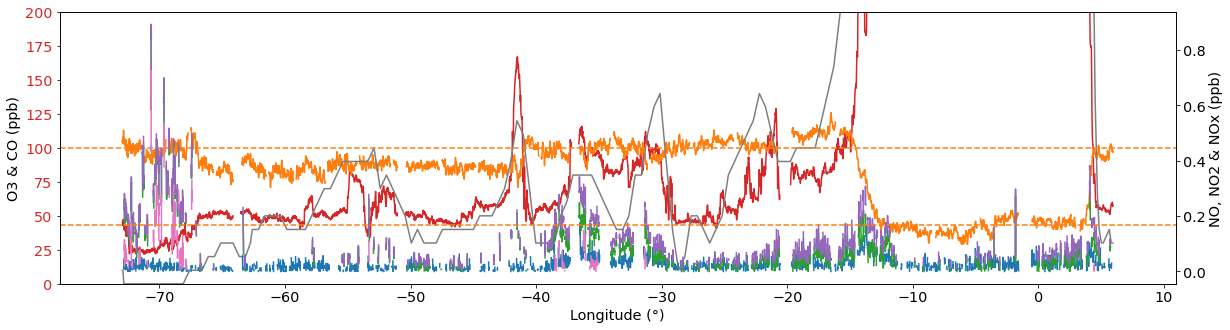

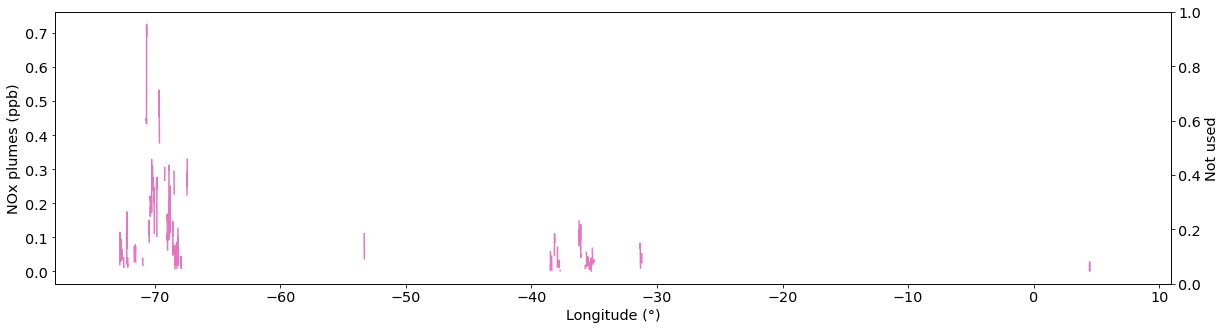

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 2
*******************************************
ANALYSING flight:  2018060415510202
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.35305825)
75th percentile NOx 0.301
***Calculating moving averages***
***Finding plumes***
***Removing planes***
5 plume(s) identified
***Plot plumes***
lon_min 1.6809000000000003
lon_max 23.3442


<Figure size 1440x360 with 0 Axes>

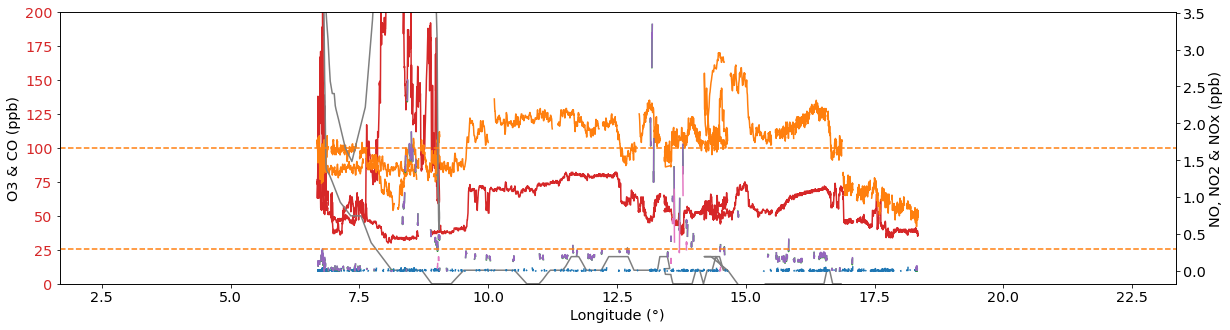

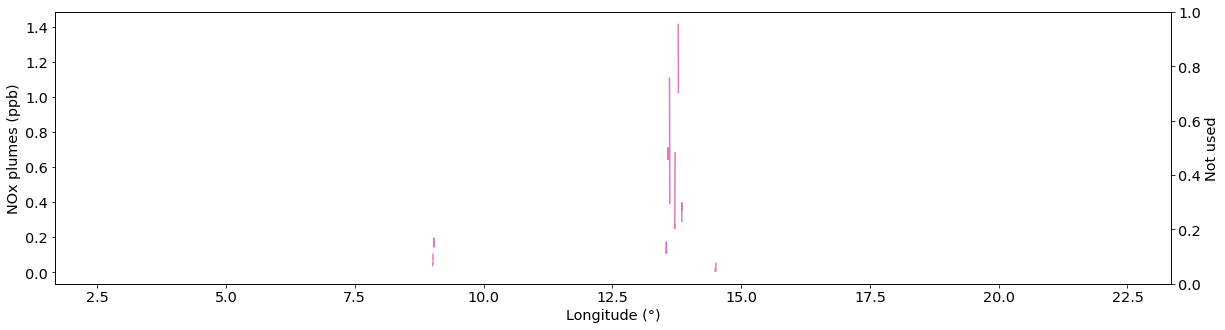

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 3
*******************************************
ANALYSING flight:  2018060508235702
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.16584759)
75th percentile NOx 0.225
***Calculating moving averages***
***Finding plumes***
***Removing planes***
6 plume(s) identified
***Plot plumes***
lon_min -119.4684
lon_max 11.9588


<Figure size 1440x360 with 0 Axes>

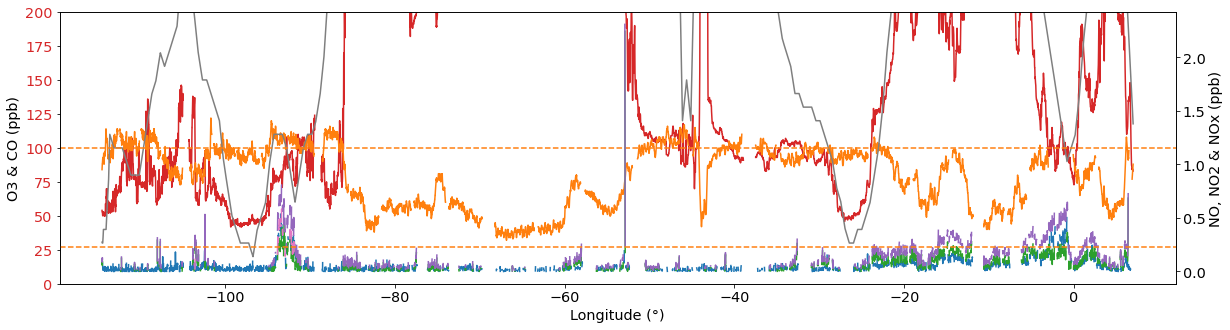

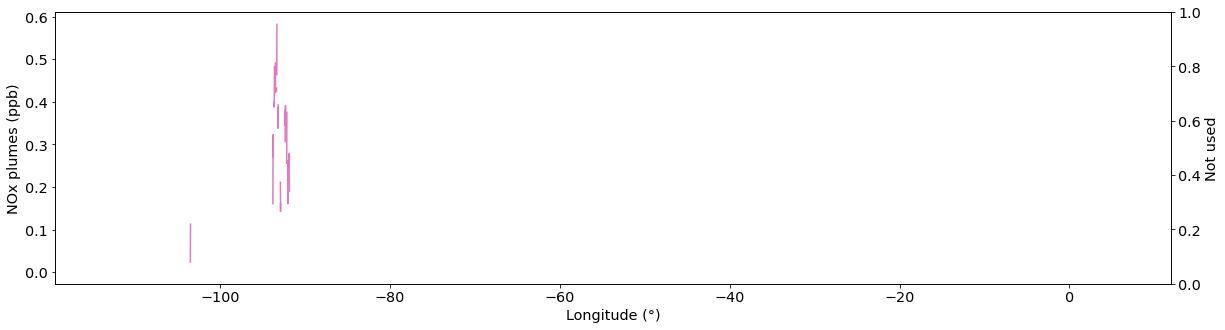

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 4
*******************************************
ANALYSING flight:  2018060522312902
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.15255923)
75th percentile NOx 0.208
***Calculating moving averages***
***Finding plumes***
***Removing planes***
1 plume(s) identified
No plumes identified, end of anaylsis for this flight
*******************************************
IAGOS-CORE 5
*******************************************
ANALYSING flight:  2018060612335502
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.16058333)
75th percentile NOx 0.22
***Calculating moving averages***
***Finding plumes***
***Removing planes***
10 plume(s) identified
***Plot plumes***
lon_min -78.0258
lon_max 10.2156


<Figure size 1440x360 with 0 Axes>

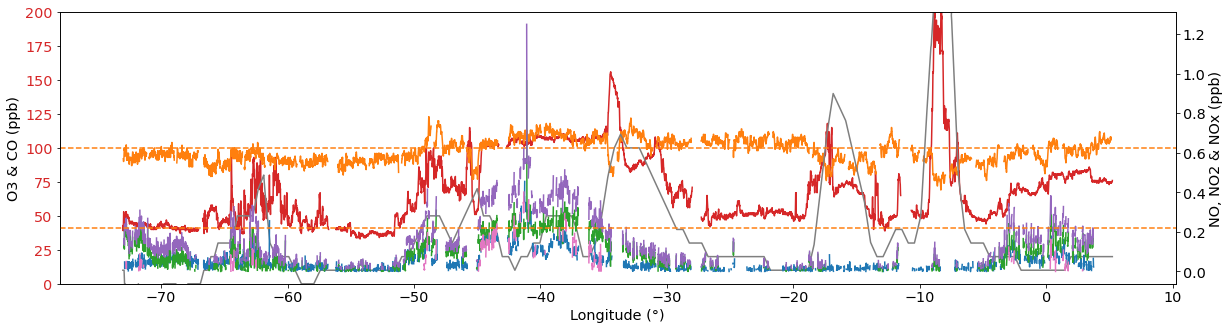

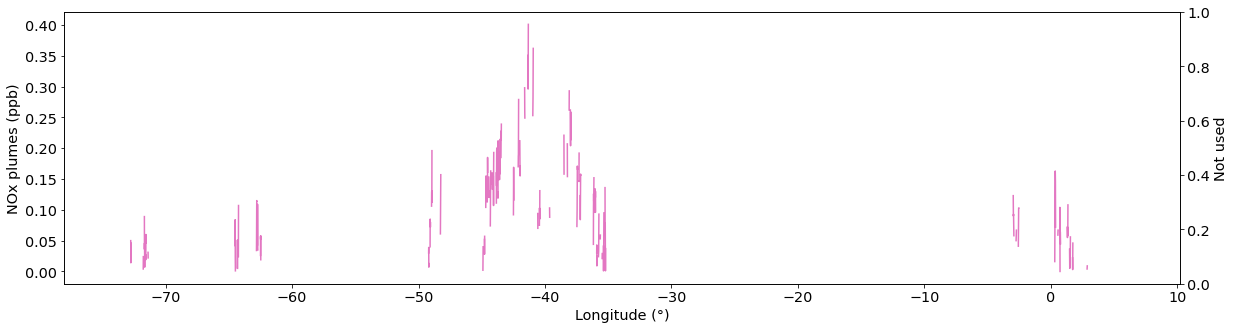

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 6
*******************************************
ANALYSING flight:  2018060702191102
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.14014812)
75th percentile NOx 0.186
***Calculating moving averages***
***Finding plumes***
***Removing planes***
17 plume(s) identified
***Plot plumes***
lon_min -78.6105
lon_max 10.2561


<Figure size 1440x360 with 0 Axes>

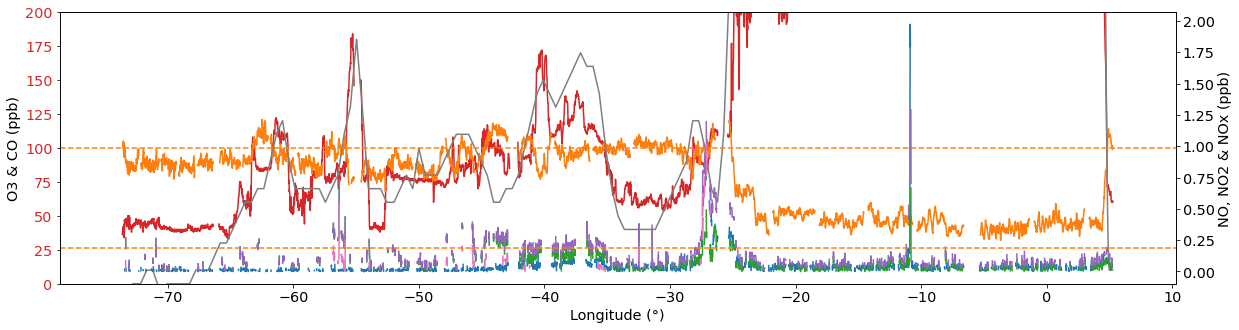

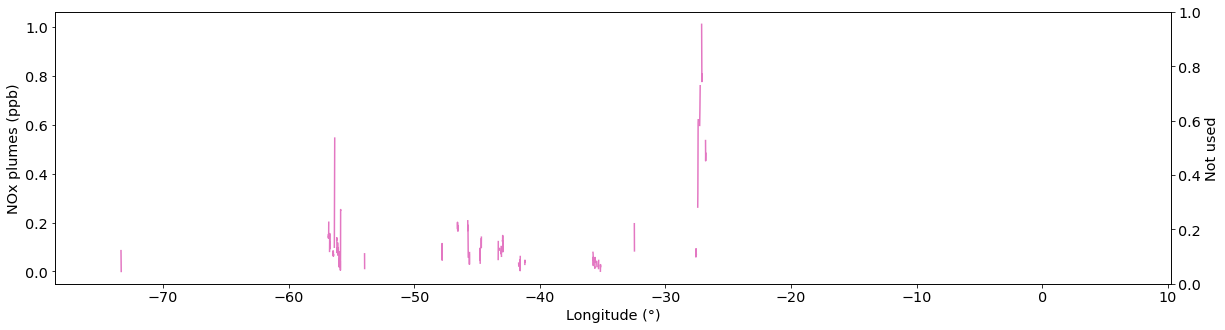

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 7
*******************************************
ANALYSING flight:  2018060717302602
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.08154518)
75th percentile NOx 0.102
***Calculating moving averages***
***Finding plumes***
***Removing planes***
3 plume(s) identified
***Plot plumes***
lon_min 4.9948
lon_max 128.107


<Figure size 1440x360 with 0 Axes>

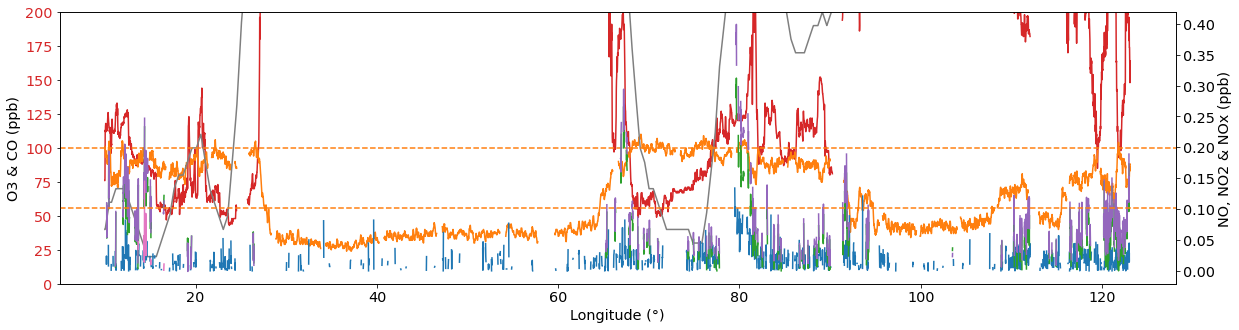

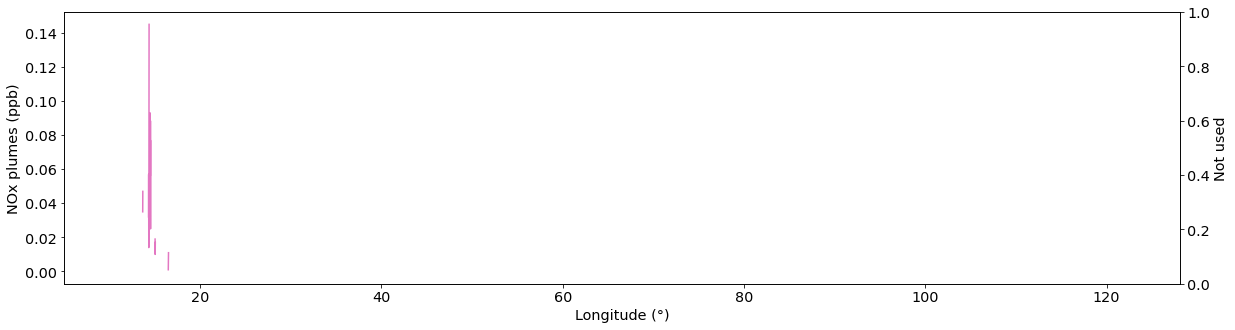

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 8
*******************************************
ANALYSING flight:  2018060805401402
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.13191006)
75th percentile NOx 0.179
***Calculating moving averages***
***Finding plumes***
***Removing planes***
4 plume(s) identified
***Plot plumes***
lon_min 7.3292
lon_max 128.6067


<Figure size 1440x360 with 0 Axes>

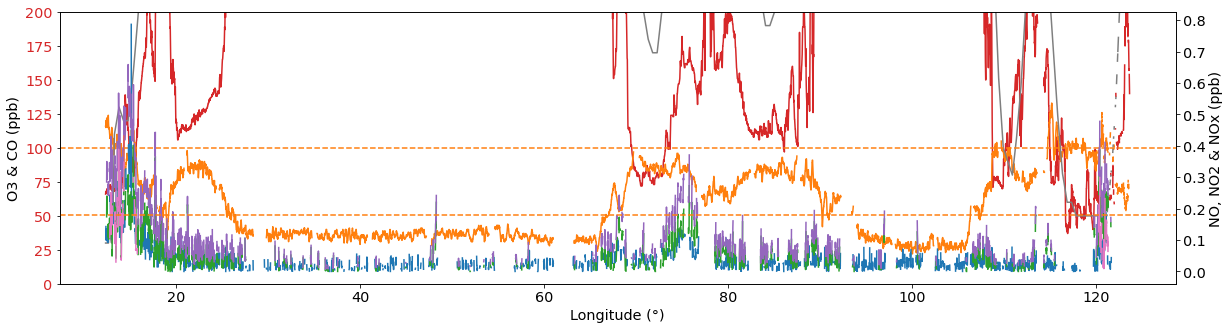

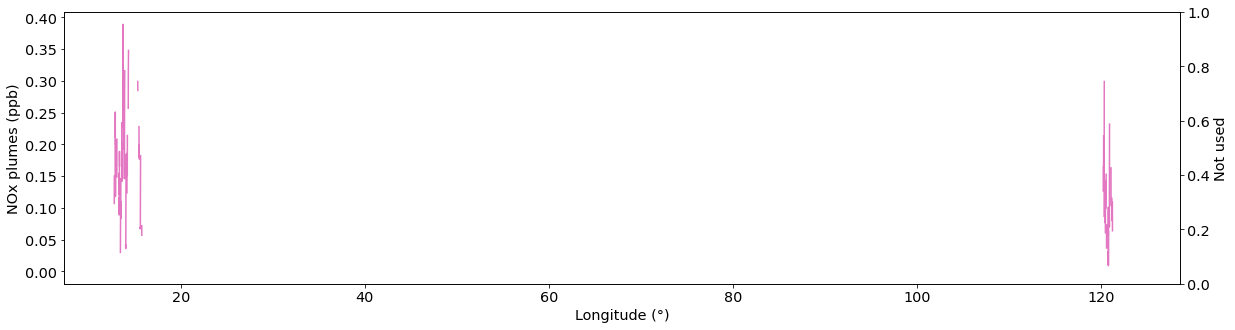

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 9
*******************************************
ANALYSING flight:  2018060922315102
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.08713048)
75th percentile NOx 0.113
***Calculating moving averages***
***Finding plumes***
***Removing planes***
3 plume(s) identified
No plumes identified, end of anaylsis for this flight
*******************************************
IAGOS-CORE 10
*******************************************
ANALYSING flight:  2018061013043302
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.2090395)
75th percentile NOx 0.25925
***Calculating moving averages***
***Finding plumes***
***Removing planes***
18 plume(s) identified
***Plot plumes***
lon_min -78.4666
lon_max 10.3167


<Figure size 1440x360 with 0 Axes>

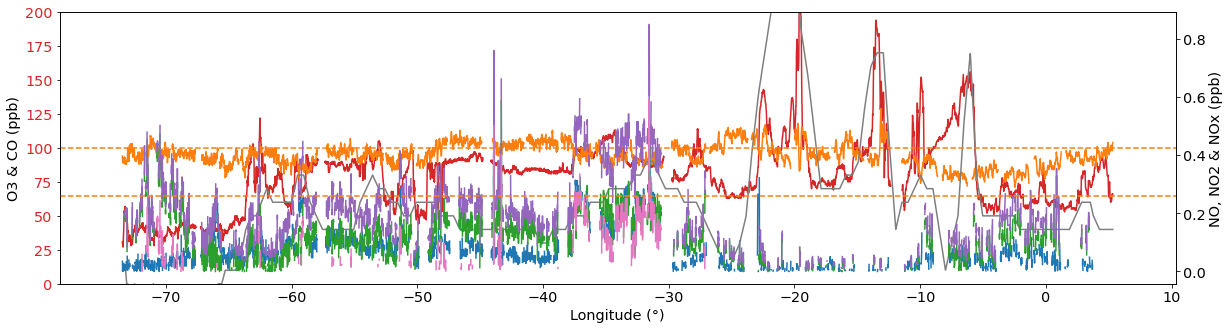

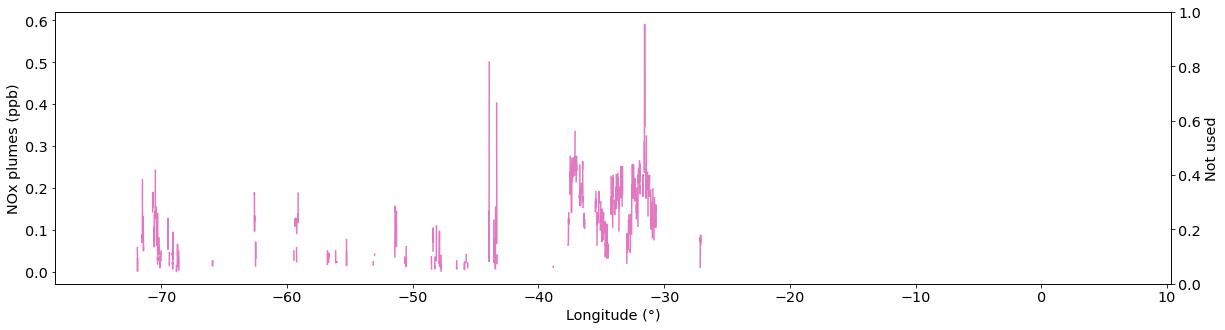

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 11
*******************************************
ANALYSING flight:  2018061102095702
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.20444994)
75th percentile NOx 0.234
***Calculating moving averages***
***Finding plumes***
***Removing planes***
14 plume(s) identified
***Plot plumes***
lon_min -78.6057
lon_max 10.964400000000001


<Figure size 1440x360 with 0 Axes>

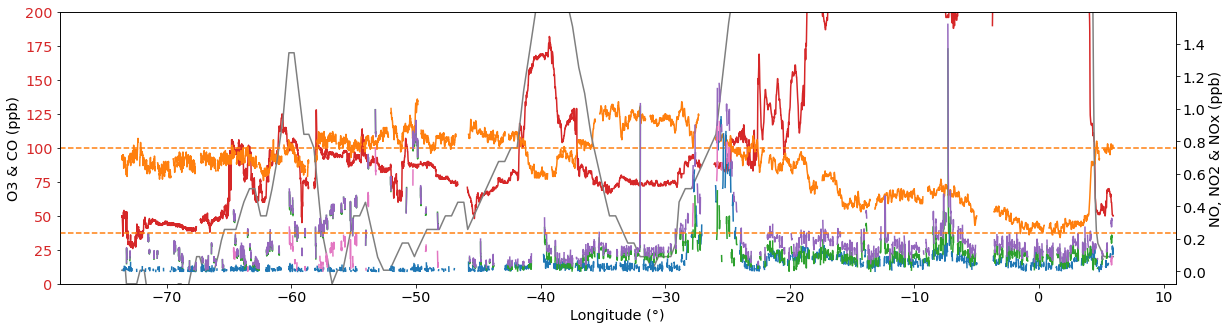

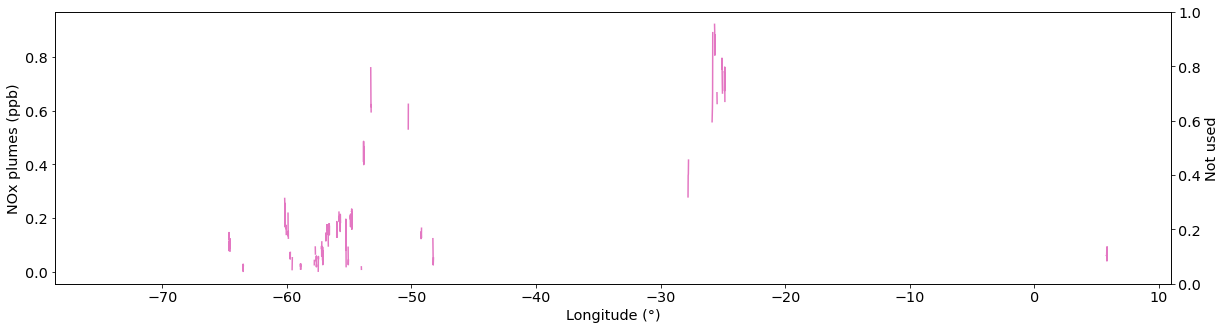

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 12
*******************************************
ANALYSING flight:  2018061116504502
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.16350092)
75th percentile NOx 0.222
***Calculating moving averages***
***Finding plumes***
***Removing planes***
4 plume(s) identified
***Plot plumes***
lon_min 6.587999999999999
lon_max 117.9424


<Figure size 1440x360 with 0 Axes>

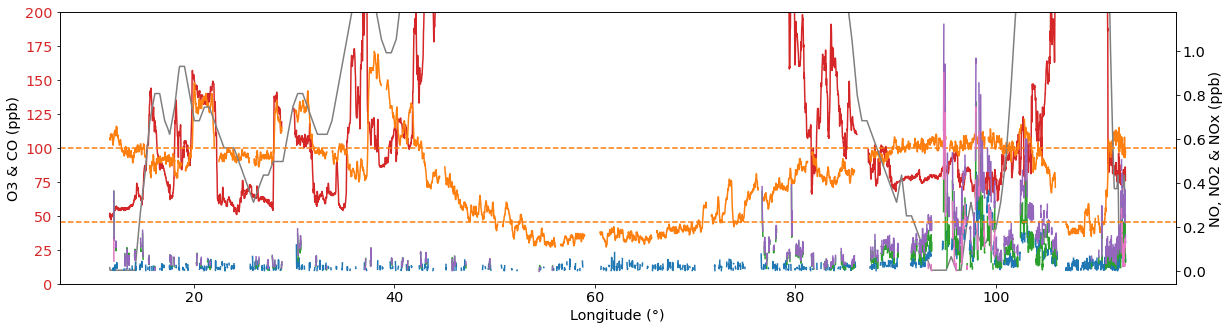

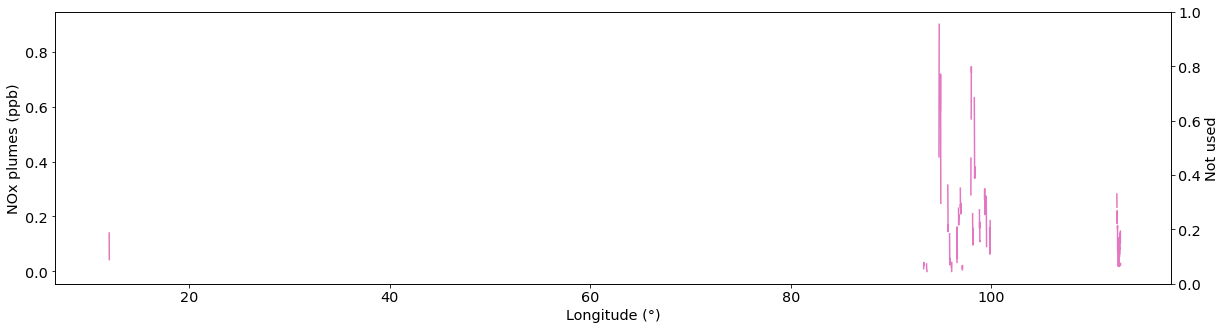

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 13
*******************************************
ANALYSING flight:  2018061205224902
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.18232536)
75th percentile NOx 0.187
***Calculating moving averages***
***Finding plumes***
***Removing planes***
5 plume(s) identified
***Plot plumes***
lon_min 6.690799999999999
lon_max 118.9777


<Figure size 1440x360 with 0 Axes>

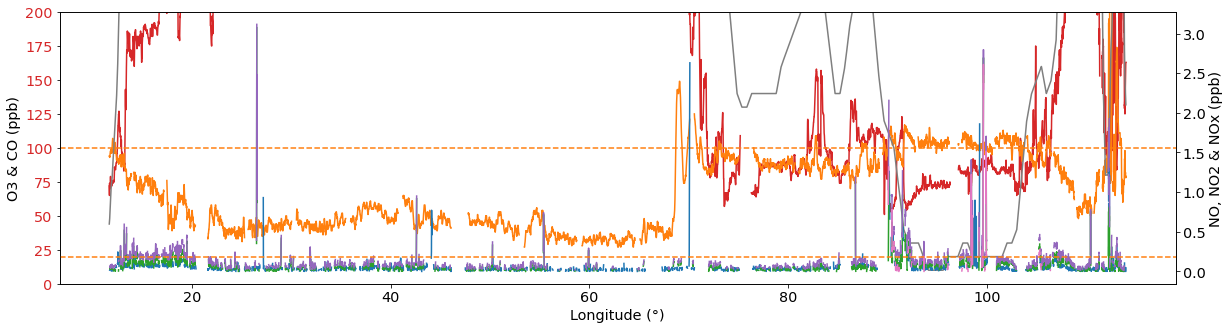

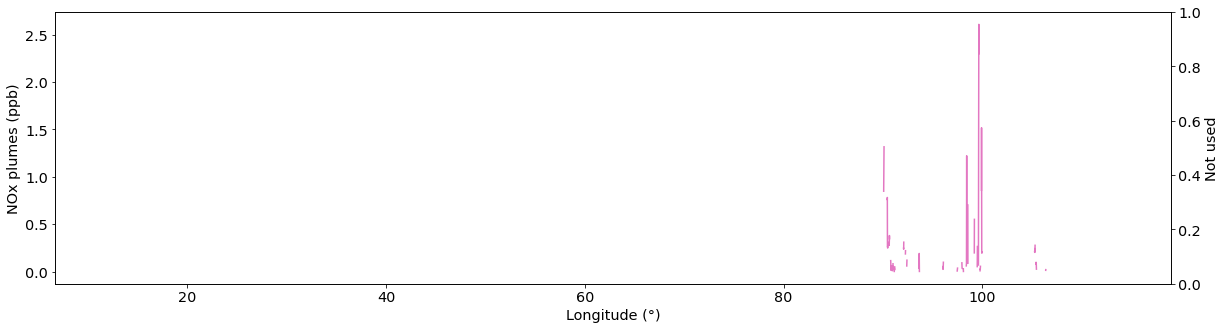

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 14
*******************************************
ANALYSING flight:  2018061316360402
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.18769365)
75th percentile NOx 0.299
***Calculating moving averages***
***Finding plumes***
***Removing planes***
4 plume(s) identified
***Plot plumes***
lon_min 5.997999999999999
lon_max 117.7254


<Figure size 1440x360 with 0 Axes>

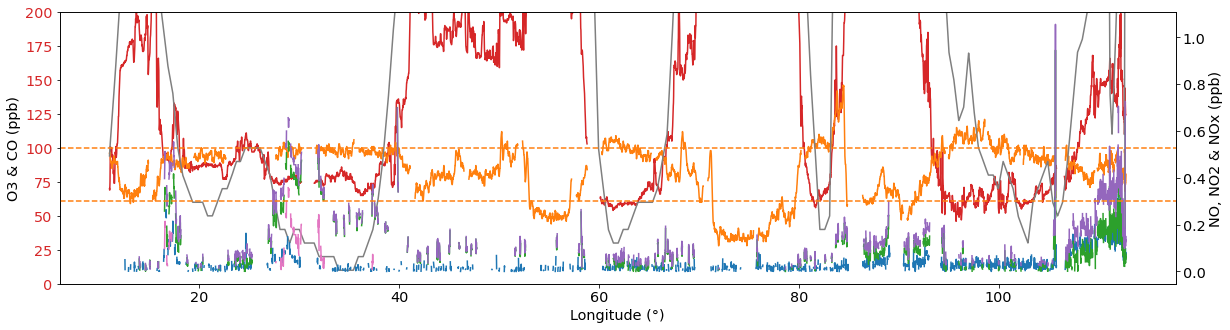

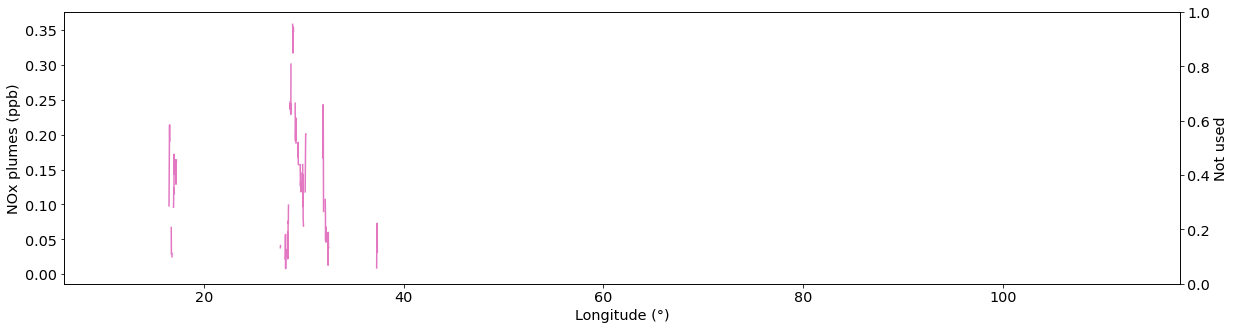

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 15
*******************************************
ANALYSING flight:  2018061405235202
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.13078019)
75th percentile NOx 0.127
***Calculating moving averages***
***Finding plumes***
***Removing planes***
13 plume(s) identified
***Plot plumes***
lon_min 6.854799999999999
lon_max 121.0991


<Figure size 1440x360 with 0 Axes>

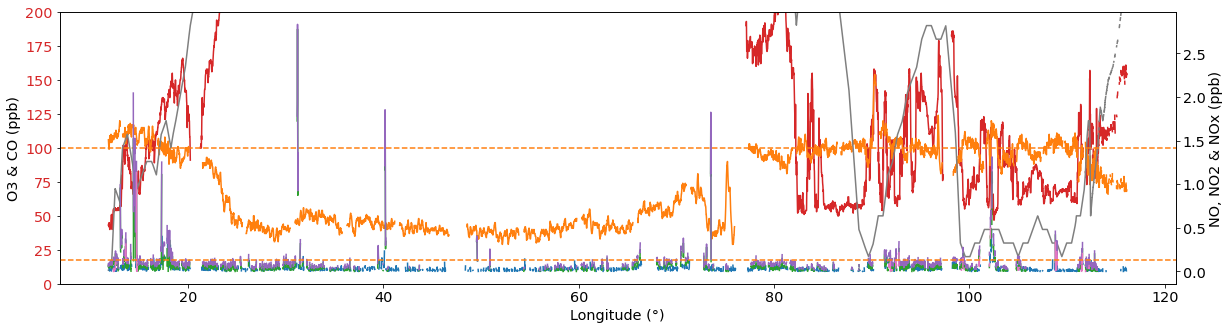

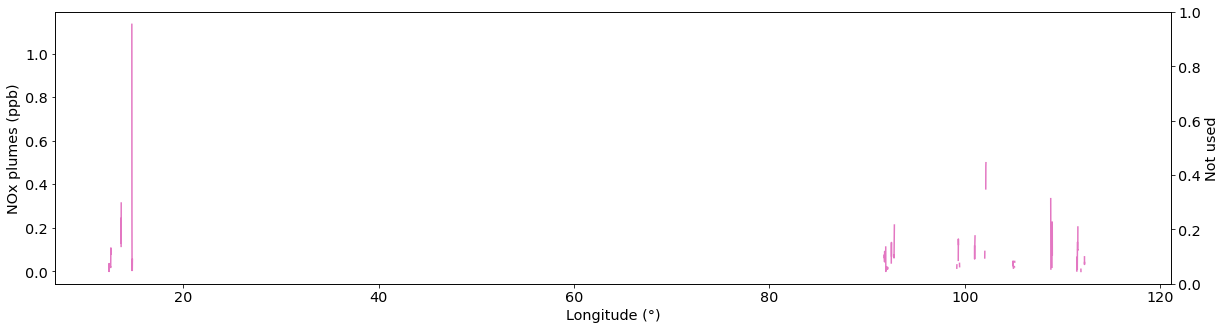

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 16
*******************************************
ANALYSING flight:  2018061520581902
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.23707708)
75th percentile NOx 0.21
***Calculating moving averages***
***Finding plumes***
***Removing planes***
12 plume(s) identified
***Plot plumes***
lon_min 7.590999999999999
lon_max 104.3404


<Figure size 1440x360 with 0 Axes>

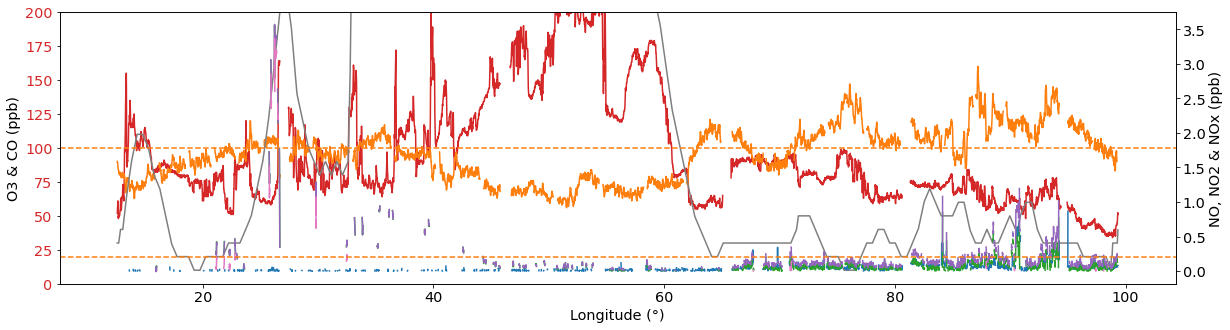

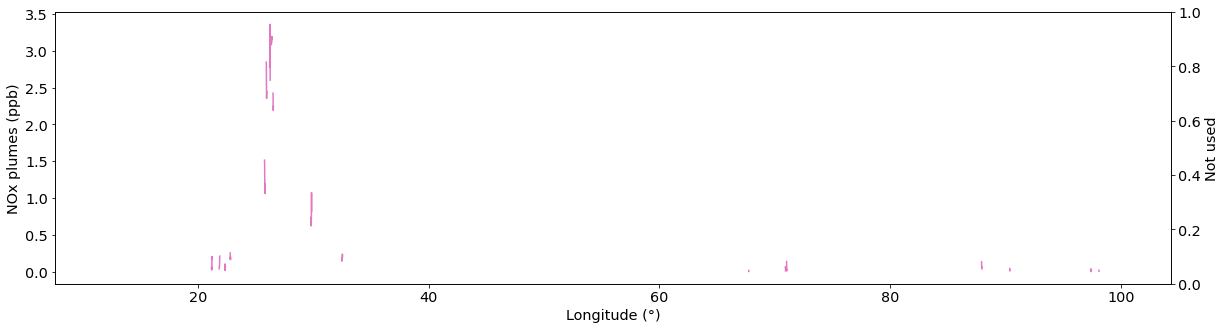

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 17
*******************************************
ANALYSING flight:  2018061616204002
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.40005405)
75th percentile NOx 0.598
***Calculating moving averages***
***Finding plumes***
***Removing planes***
7 plume(s) identified
***Plot plumes***
lon_min 6.2555
lon_max 94.2742


<Figure size 1440x360 with 0 Axes>

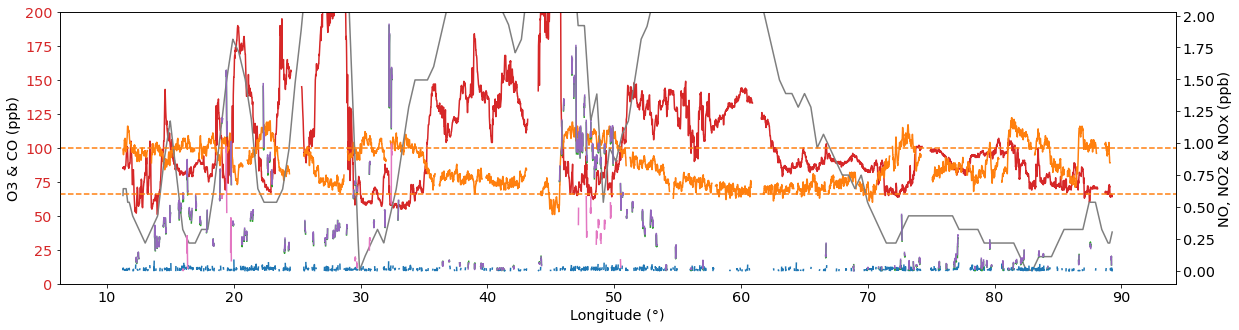

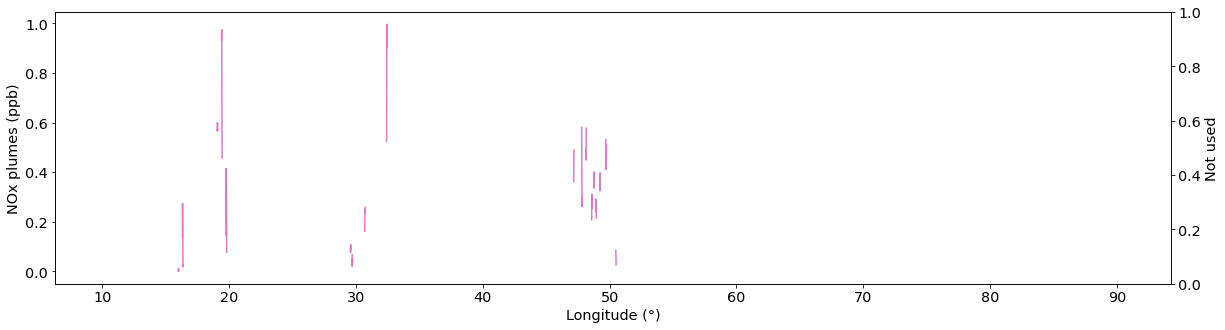

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 18
*******************************************
ANALYSING flight:  2018061712343202
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.12586025)
75th percentile NOx 0.159
***Calculating moving averages***
***Finding plumes***
***Removing planes***
13 plume(s) identified
***Plot plumes***
lon_min -78.1707
lon_max 9.8833


<Figure size 1440x360 with 0 Axes>

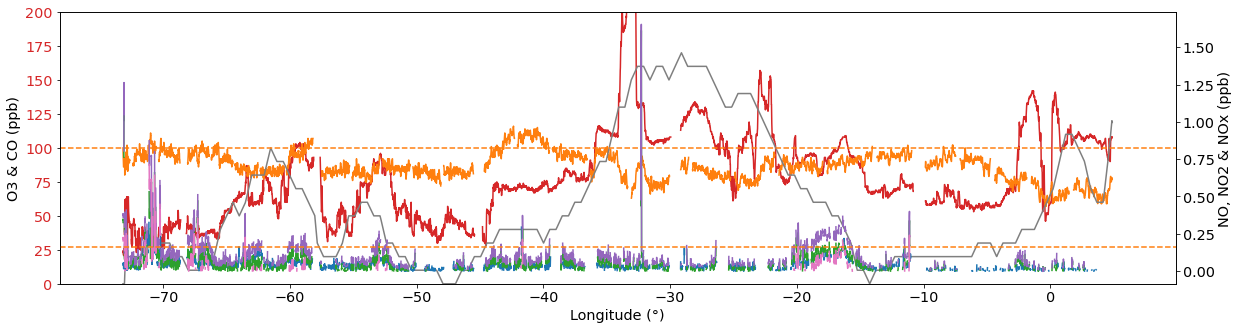

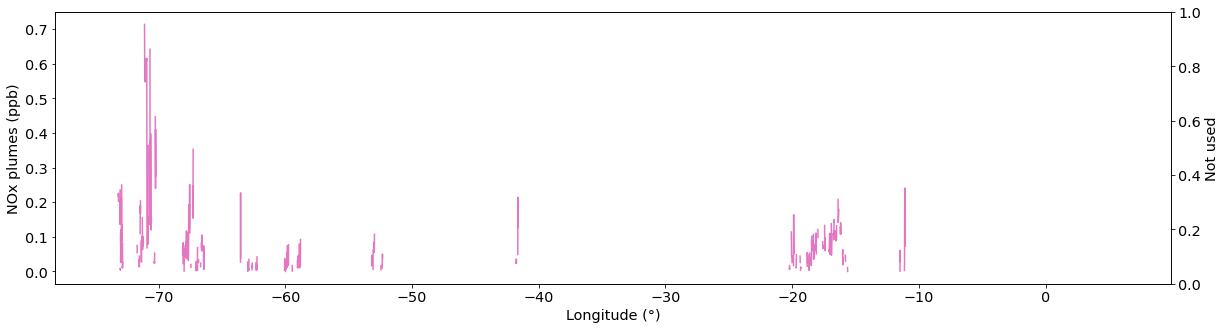

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 19
*******************************************
ANALYSING flight:  2018061802164802
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.18820661)
75th percentile NOx 0.222
***Calculating moving averages***
***Finding plumes***
***Removing planes***
13 plume(s) identified
***Plot plumes***
lon_min -78.5116
lon_max 10.9247


<Figure size 1440x360 with 0 Axes>

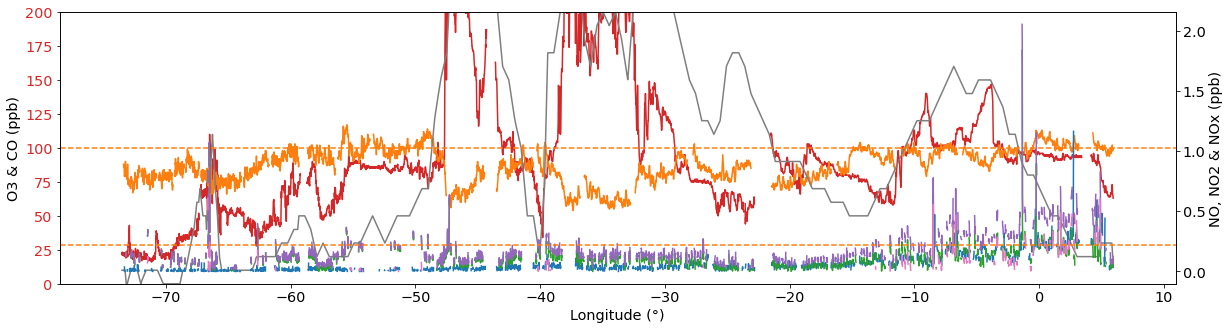

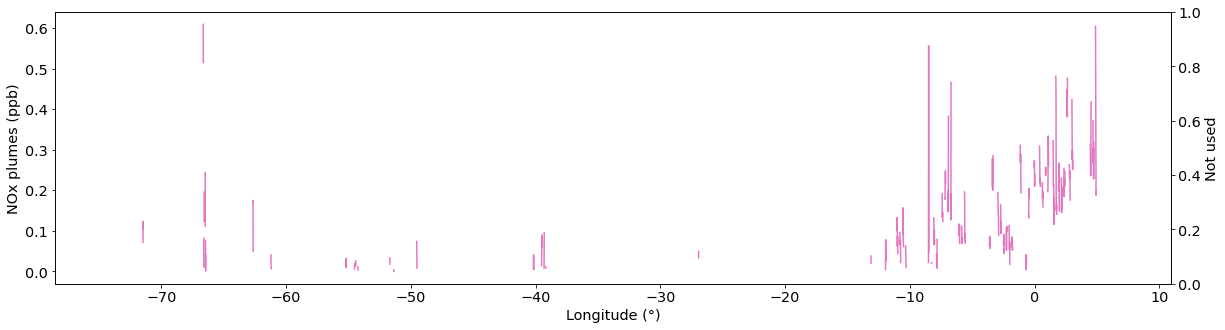

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 20
*******************************************
ANALYSING flight:  2018061816135702
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.15250915)
75th percentile NOx 0.183
***Calculating moving averages***
***Finding plumes***
***Removing planes***
9 plume(s) identified
***Plot plumes***
lon_min 6.5061
lon_max 128.2832


<Figure size 1440x360 with 0 Axes>

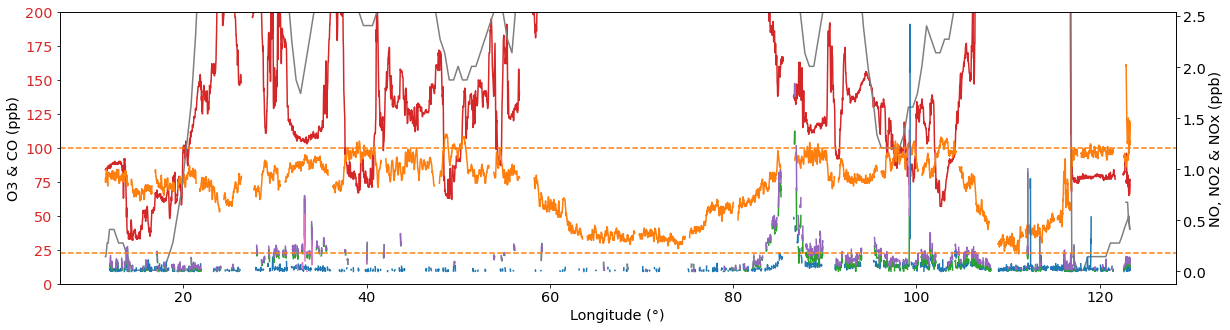

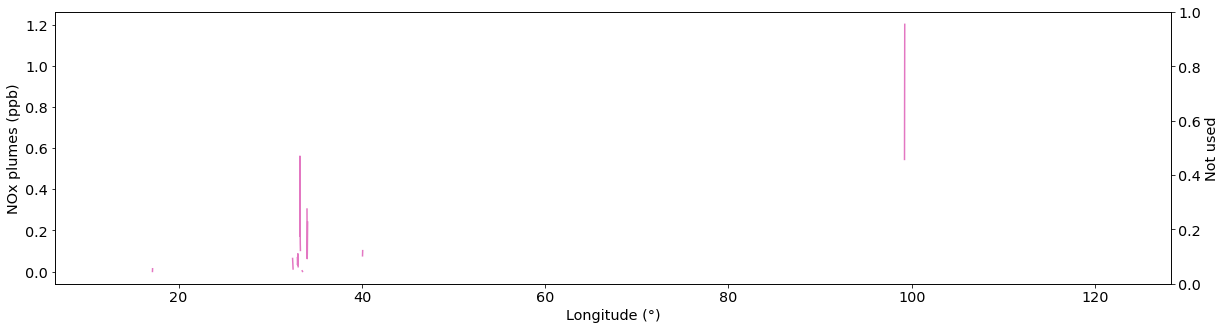

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 21
*******************************************
ANALYSING flight:  2018061905071302
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.20620701)
75th percentile NOx 0.1895
***Calculating moving averages***
***Finding plumes***
***Removing planes***
5 plume(s) identified
***Plot plumes***
lon_min 7.041499999999999
lon_max 127.9329


<Figure size 1440x360 with 0 Axes>

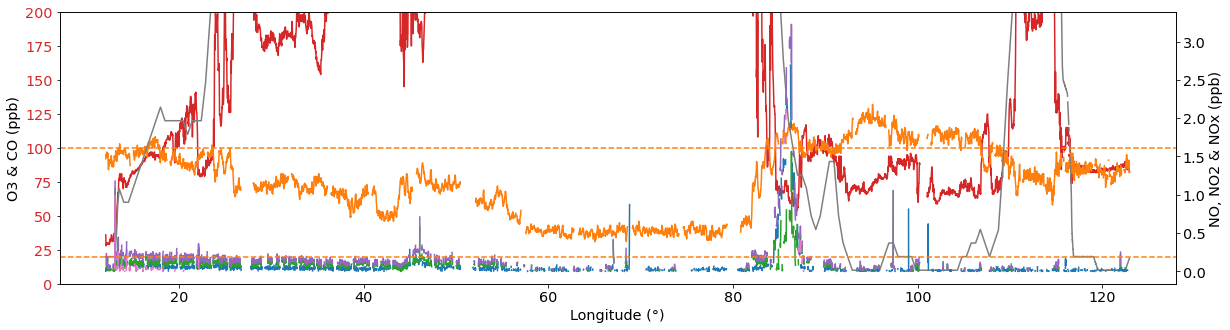

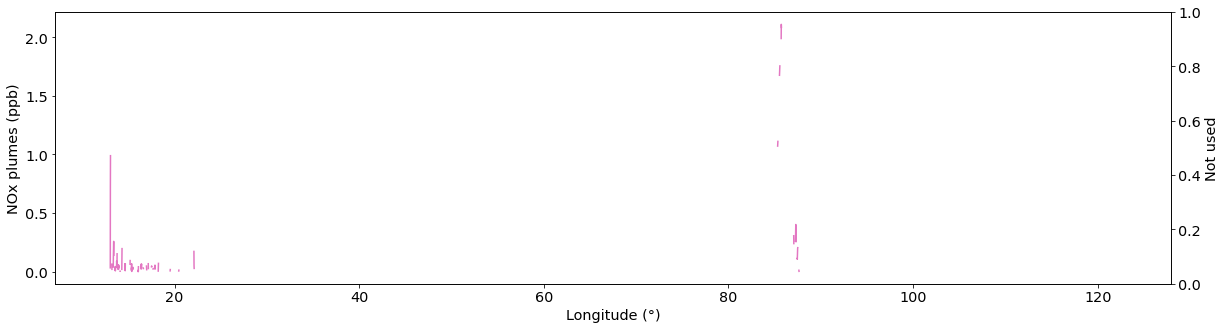

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 22
*******************************************
ANALYSING flight:  2018062016102802
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.11217629)
75th percentile NOx 0.156
***Calculating moving averages***
***Finding plumes***
***Removing planes***
1 plume(s) identified
No plumes identified, end of anaylsis for this flight
*******************************************
IAGOS-CORE 23
*******************************************
ANALYSING flight:  2018062105012002
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.11129733)
75th percentile NOx 0.132
***Calculating moving averages***
***Finding plumes***
***Removing planes***
4 plume(s) identified
***Plot plumes***
lon_min 6.9818
lon_max 128.2022


<Figure size 1440x360 with 0 Axes>

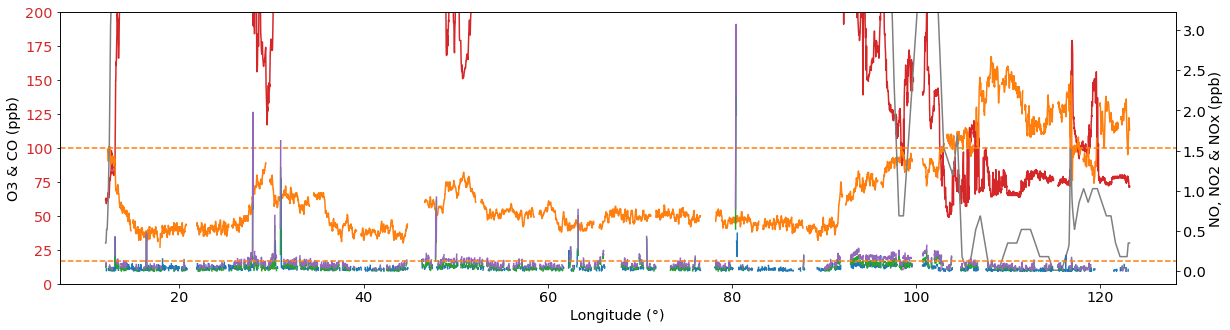

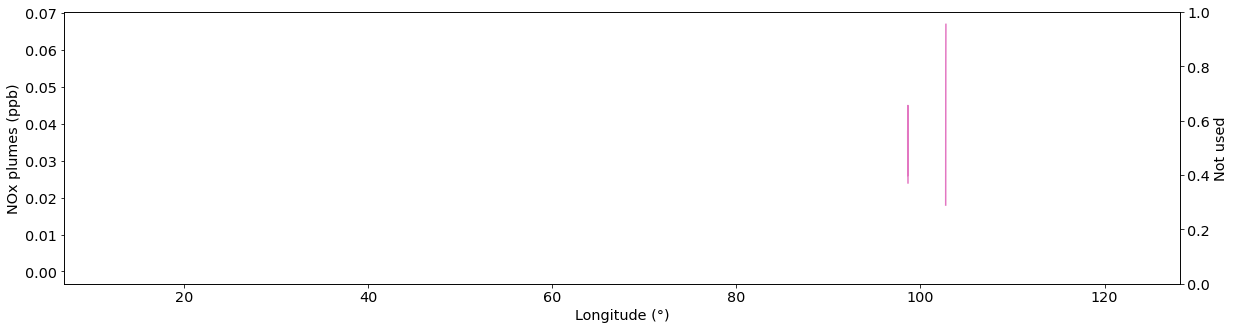

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 24
*******************************************
ANALYSING flight:  2018062120370302
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.21900838)
75th percentile NOx 0.21975
***Calculating moving averages***
***Finding plumes***
***Removing planes***
11 plume(s) identified
***Plot plumes***
lon_min 6.6838
lon_max 104.4879


<Figure size 1440x360 with 0 Axes>

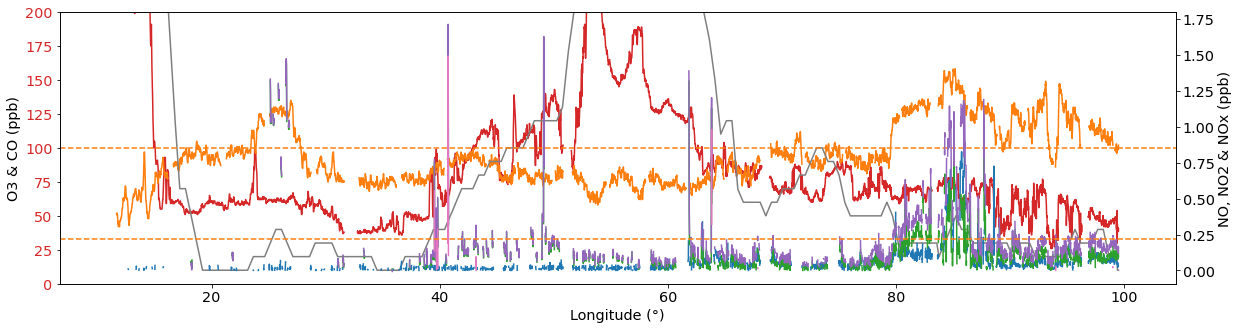

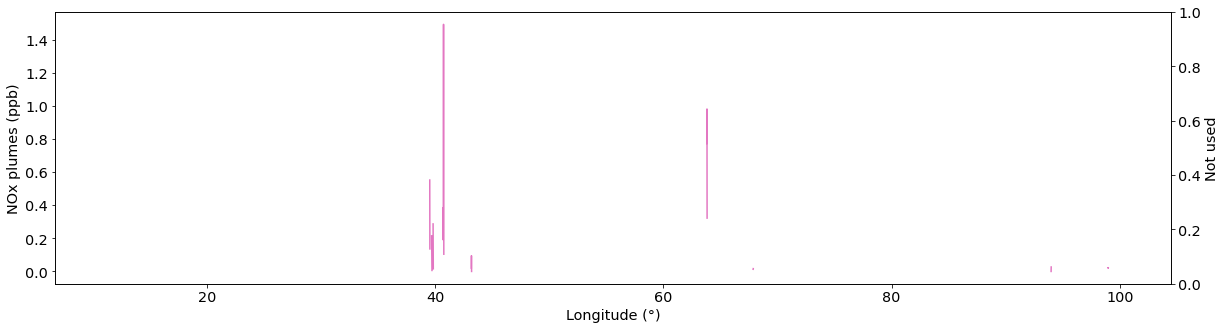

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 25
*******************************************
ANALYSING flight:  2018062216171602
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.2363949)
75th percentile NOx 0.244
***Calculating moving averages***
***Finding plumes***
***Removing planes***
6 plume(s) identified
***Plot plumes***
lon_min 7.1190999999999995
lon_max 103.3362


<Figure size 1440x360 with 0 Axes>

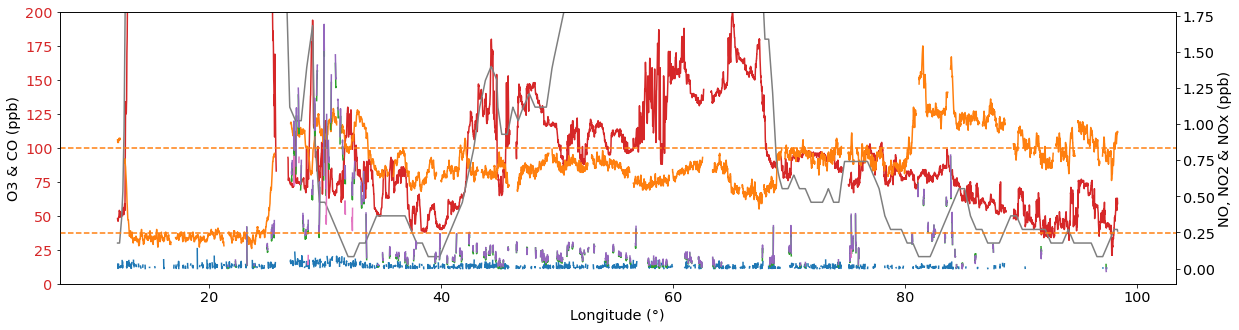

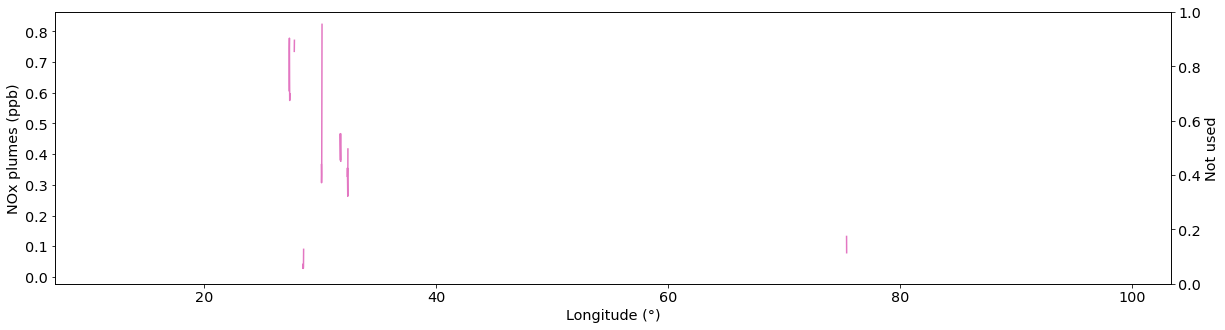

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 26
*******************************************
ANALYSING flight:  2018062312572002
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.14849758)
75th percentile NOx 0.17075
***Calculating moving averages***
***Finding plumes***
***Removing planes***
19 plume(s) identified
***Plot plumes***
lon_min -79.3462
lon_max 9.729099999999999


<Figure size 1440x360 with 0 Axes>

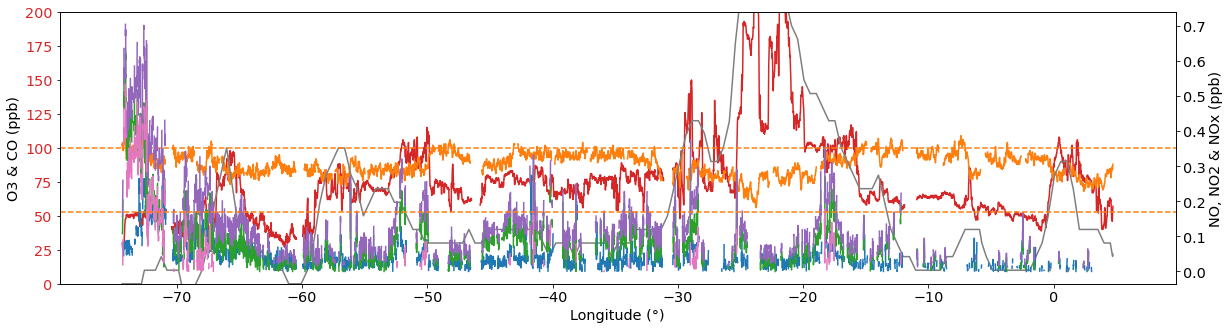

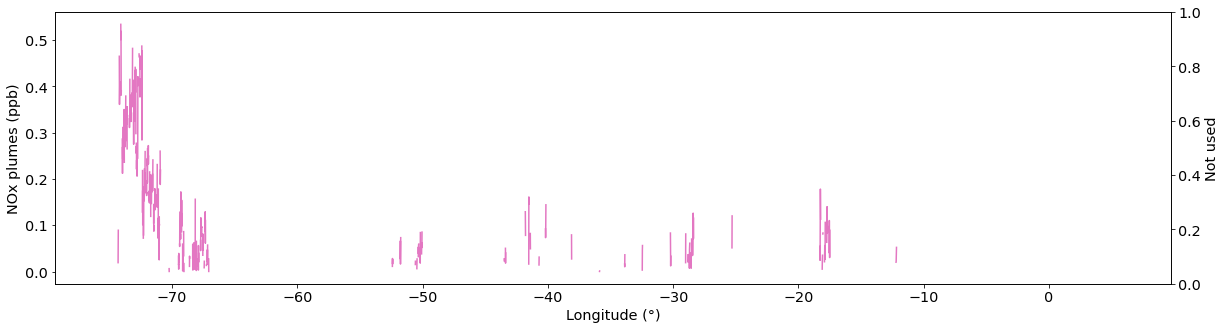

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 27
*******************************************
ANALYSING flight:  2018062402164402
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.1245142)
75th percentile NOx 0.153
***Calculating moving averages***
***Finding plumes***
***Removing planes***
20 plume(s) identified
***Plot plumes***
lon_min -78.6364
lon_max 12.039


<Figure size 1440x360 with 0 Axes>

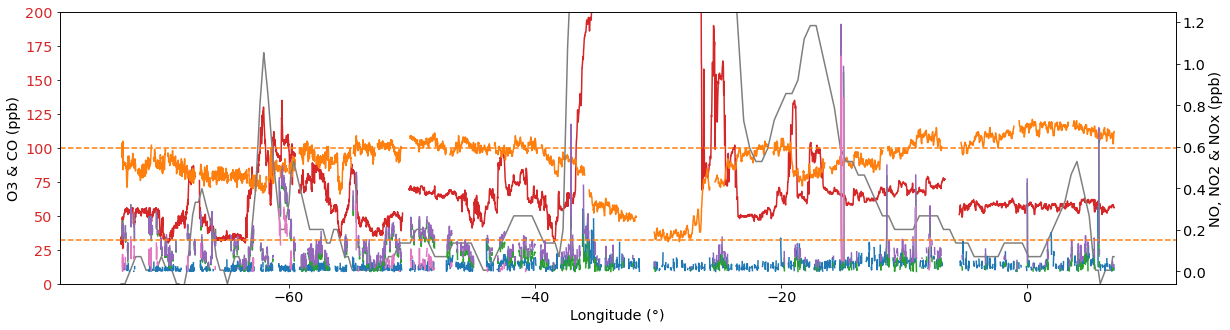

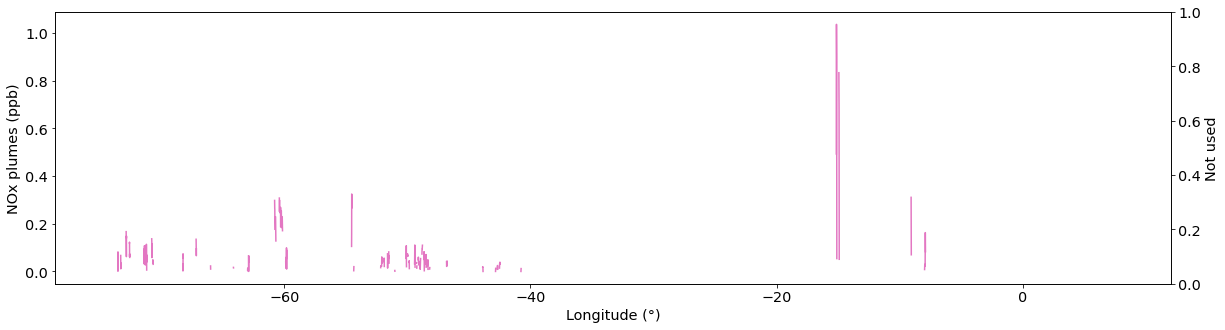

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 28
*******************************************
ANALYSING flight:  2018062416375602
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.13169328)
75th percentile NOx 0.159
***Calculating moving averages***
***Finding plumes***
***Removing planes***
12 plume(s) identified
***Plot plumes***
lon_min 7.141299999999999
lon_max 117.9317


<Figure size 1440x360 with 0 Axes>

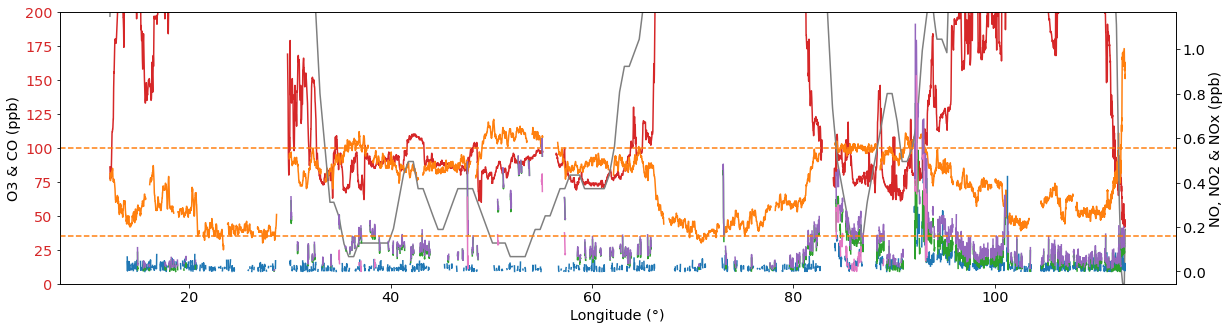

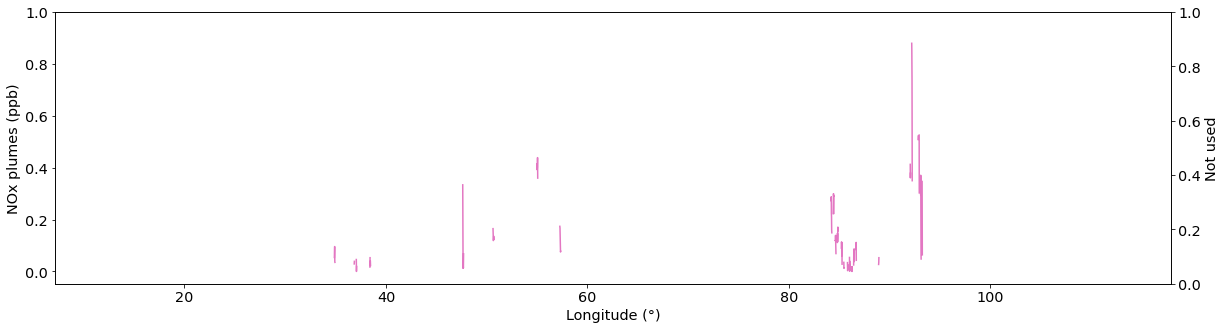

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 29
*******************************************
ANALYSING flight:  2018062713274902
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.13685792)
75th percentile NOx 0.164
***Calculating moving averages***
***Finding plumes***
***Removing planes***
15 plume(s) identified
***Plot plumes***
lon_min -78.4361
lon_max 6.0106


<Figure size 1440x360 with 0 Axes>

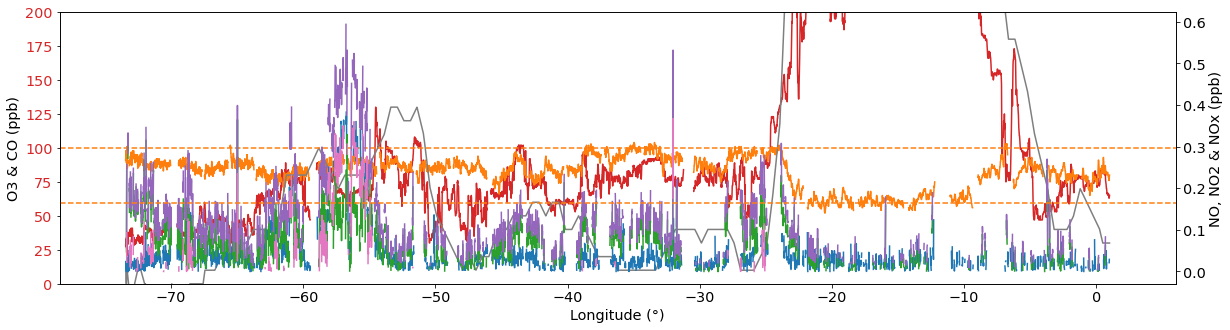

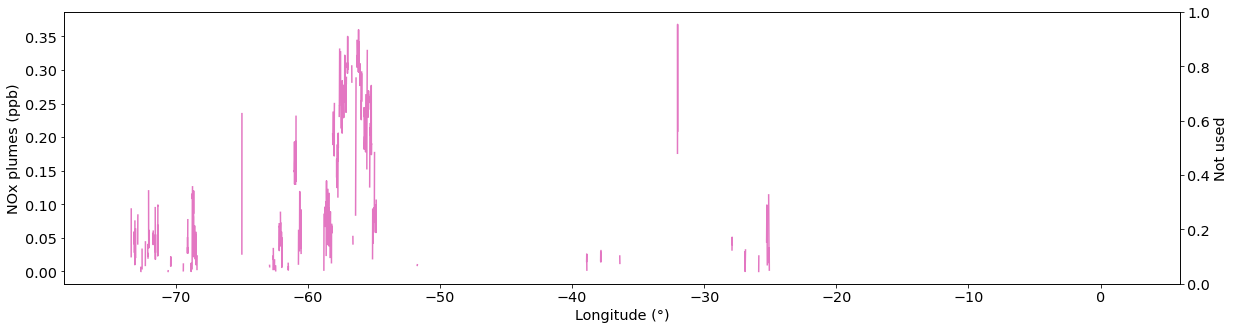

***Extract datetime info***
***Writing plume info***
*******************************************
IAGOS-CORE 30
*******************************************
ANALYSING flight:  2018072516314402
*******************************************
***Applying cuts***
Mean NOx <xarray.DataArray 'NOx_P2b' ()>
array(0.19924512)
75th percentile NOx 0.181
***Calculating moving averages***
***Finding plumes***
***Removing planes***
8 plume(s) identified
***Plot plumes***
lon_min 6.668900000000001
lon_max 128.287


<Figure size 1440x360 with 0 Axes>

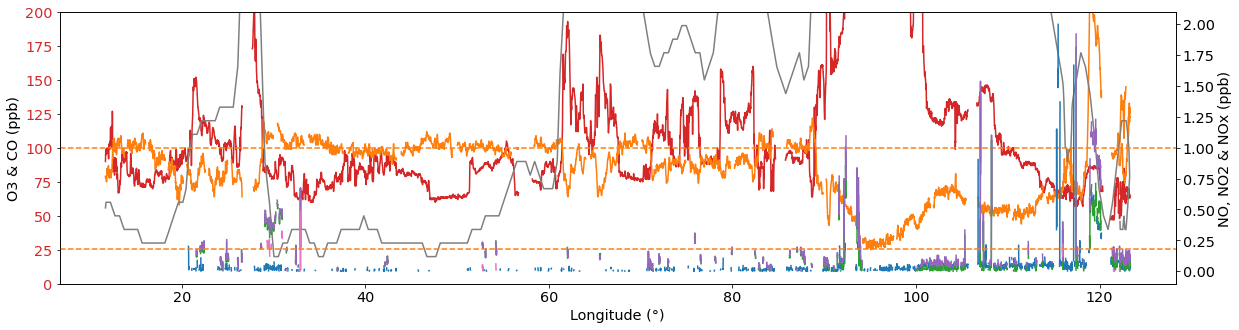

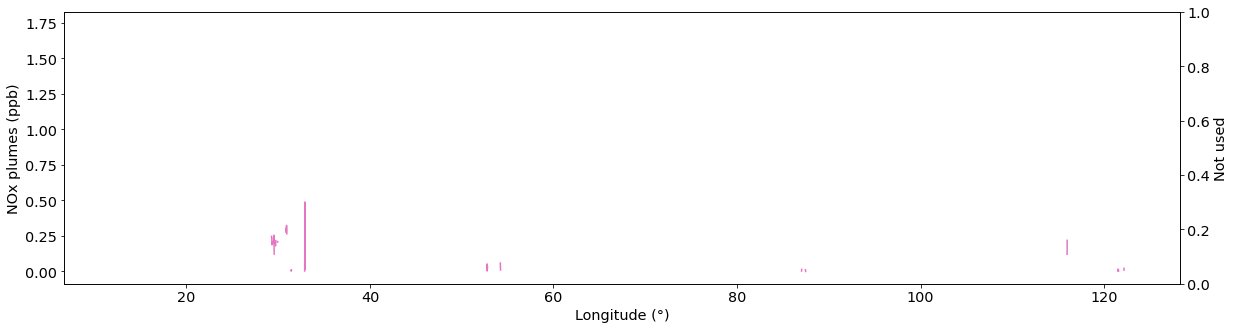

***Extract datetime info***
***Writing plume info***


<xarray.Dataset>
Dimensions:               (UTC_time: 9485)
Coordinates:
  * UTC_time              (UTC_time) datetime64[ns] 2018-07-25T16:32:00 ... 2...
Data variables:
    lon                   (UTC_time) float64 8.547 8.55 8.553 ... 120.4 120.4
    lat                   (UTC_time) float64 50.03 50.04 50.04 ... 36.27 36.27
    baro_alt_AC           (UTC_time) float64 111.2 111.2 110.3 ... 60.3 63.7
    baro_alt_AC_val       (UTC_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    radio_alt_AC          (UTC_time) float64 0.1 0.2 0.2 0.3 ... 2.3 0.0 0.2 0.2
    gps_alt_AC            (UTC_time) float64 107.9 108.2 108.8 ... 21.0 20.7
    air_press_AC          (UTC_time) float64 9.999e+04 1e+05 ... 1.006e+05
    air_press_AC_val      (UTC_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    air_speed_AC          (UTC_time) float64 53.0 60.0 66.0 ... 71.0 63.0 55.0
    air_speed_AC_val      (UTC_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ground_speed_AC       (UTC_time) float64 54.0 60.0 66.0 ... 72.0 65.0 58.0
    ground_speed_AC_val   (UTC_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    air_temp_AC           (UTC_time) float64 306.6 306.9 306.6 ... 306.9 306.6
    air_temp_AC_val       (UTC_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    air_stag_temp_AC      (UTC_time) float64 307.9 308.6 308.9 ... 308.9 308.1
    air_stag_temp_AC_val  (UTC_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wind_dir_AC           (UTC_time) float64 253.3 277.6 272.1 ... 356.0 344.7
    wind_speed_AC         (UTC_time) float64 1.5 1.0 0.5 0.5 ... 3.1 0.0 1.0 2.6
    zon_wind_AC           (UTC_time) float64 1.48 1.02 0.51 ... -0.0 0.07 0.68
    mer_wind_AC           (UTC_time) float64 0.44 -0.14 -0.02 ... -1.03 -2.48
    O3_P1                 (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    O3_P1_err             (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    O3_P1_stat            (UTC_time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    O3_P1_val             (UTC_time) float64 7.0 7.0 7.0 7.0 ... 7.0 7.0 7.0 7.0
    CO_P1                 (UTC_time) float64 nan nan nan ... 617.0 579.0 552.0
    CO_P1_err             (UTC_time) float64 nan nan nan ... 35.85 33.95 32.6
    CO_P1_stat            (UTC_time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    CO_P1_val             (UTC_time) float64 7.0 7.0 7.0 7.0 ... 0.0 0.0 0.0 0.0
    cloud_P1              (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    cloud_P1_err          (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    cloud_P1_stat         (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    cloud_P1_val          (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    cloud_presence_P1     (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    NO_P2b                (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NO_P2b_err            (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NO_P2b_val            (UTC_time) float64 7.0 7.0 7.0 7.0 ... 7.0 7.0 7.0 7.0
    NO2_P2b               (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NO2_P2b_err           (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NO2_P2b_val           (UTC_time) float64 7.0 7.0 7.0 7.0 ... 7.0 7.0 7.0 7.0
    NOx_P2b               (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NOx_P2b_err           (UTC_time) float64 -9.999e+03 ... -9.999e+03
    NOx_P2b_val           (UTC_time) float64 7.0 7.0 7.0 7.0 ... 7.0 7.0 7.0 7.0
    PV                    (UTC_time) float64 nan nan nan nan ... nan nan nan nan
    data_vars_cruise      (UTC_time) bool False False False ... False False
    data_status_CO        (UTC_time) bool False False False ... True True True
    data_status_O3        (UTC_time) bool False False False ... False False
    data_status_NO        (UTC_time) bool False False False ... False False
    data_status_NO2       (UTC_time) bool False False False ... False False
    data_status_NOx       (UTC_time) bool False False False ...

<Figure size 1440x360 with 0 Axes>

In [40]:
# Run the provide_flight_info to find and isolate plumes

provide_flight_info(flights_with_NOx)